# Phase 1: Residential Building Consent Dataset

## INPUTS
1.	Geocoded individual consent data  
Various information (specified below under OUTPUTS) need to be added to each observation in these two datasets 
-	csv file containing building consents for 2000 to 2020 [filename: BCs_issued_by_AUP_TLADCs_2021FEB.csv]
2.	LINZ spine from phase 0

## OUTPUTS
csv file of building consents with the data fields 1-9 above. The matching process for assigning each consent to a LINZ parcel is described below. 
The following additional data fields are added. These are flags to designate the match to the LINZ dataset.

10.	Ranged Address Indicator  
a.	Indicator (1 or 0) for LINZ parcel that is part of a ranged address consent Ranged_Address_indicator

In [4]:
#pragma nodebook off
#Use nodebook for better reproducibility https://github.com/uoa-eResearch/nodebook
%reload_ext nodebook.ipython
%nodebook disk phase1

<IPython.core.display.Javascript object>

In [5]:
# load libraries
import geopandas as gpd # vector data
import pandas as pd # tabular data, loading CSVs
import numpy as np # numeric data
from util import *
import matplotlib # plotting
import contextily as ctx # Used for contextual basemaps
from scipy.spatial import cKDTree
from matplotlib_scalebar.scalebar import ScaleBar # scalebar for plot
import matplotlib.pyplot as plt # plotting
from tqdm.auto import tqdm # progress bars
tqdm.pandas()
import requests
import requests_cache
requests_cache.install_cache('requests_cache')
import json
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon  # creating points
plt.rcParams['figure.figsize'] = (20, 20)
pd.set_option('max_columns', None)
pd.set_option('max_rows', 300)

In [6]:
%%time
df = pd.read_csv("restricted/BCs_issued_by_AUP_TLADCs_2021FEB.csv", encoding='cp1252')
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate), crs=4326)

CPU times: user 1.24 s, sys: 210 ms, total: 1.45 s
Wall time: 1.46 s


In [7]:
df

OBS              CONSENT_DATE                MARCH_YEAR  \
0       227614  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
1       227656  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
2       227796  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
3       227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4       227902  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...        ...                       ...                       ...   
207221  151352  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207222  151351  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207223  151350  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207224  151349  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207225  151348  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                    ADDRESS_1        ADDRESS_2         ADDRESS_3  \
0       398 PAKIRI BLOCK ROAD         Tomarata          Auckland   
1                 Ahuroa Road            Puhoi          Auckland   
2            Upper Orewa Road      Upper Orewa          Auckland   
3            56 VINISTRA ROAD           Huapai          Auckland   
4            77 VINISTRA ROAD           Huapai          Auckland   
...                       ...              ...               ...   
207221                164-168        HOBSON ST          AUCKLAND   
207222                    464       REMUERA RD           REMUERA   
207223                    55B      PANORAMA RD  MOUNT WELLINGTON   
207224                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   
207225                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   

                      LB_Name  \
0                      Rodney   
1                      Rodney   
2                      Rodney   
3                      Rodney   
4                      Rodney   
...                       ...   
207221              Waitemata   
207222                 Orakei   
207223  Maungakiekie - Tamaki   
207224              Waitemata   
207225              Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses                1111   
1                               Non-building construction                3111   
2           Townhouses, flats, units, and other dwellings                1129   
3                                                  Houses                1111   
4                                                  Houses                1111   
...                                                   ...                 ...   
207221                                          New Flats                1200   
207222                                          New Flats                1200   
207223  New (and pre-built) house, unit, bach, crib, b...                1100   
207224                                        New Offices                1461   
207225  New Hotels - excludes taverns, hotel bars and ...                1411   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN          1         Residential         Detached   
1              0.0        NaN          1               Other              NaN   
2            260.0        NaN          2         Residential         Attached   
3            179.0        NaN          1         Residential         Detached   
4            180.0        NaN          1         Residential         Detached   
...            ...        ...        ...                 ...              ...   
207221         0.0  3650000.0          0         Residential         Attached   
207222         0.0   120000.0          0         Residential         Attached   
207223       140.0   200000.0          1         Residential         Detached   
207224         0.0        0.0          1            Business              NaN   
207225      8974.0   500000.0          1            Business              NaN   

       Bus

In [8]:
df["Ranged_Address_indicator"] = df.ADDRESS_1.str.contains('\d\w?\s?-', regex=True, na=False)
df["Ranged_Address_indicator"].value_counts()

False    200848
True       6378
Name: Ranged_Address_indicator, dtype: int64

11.	Matching Type Indicators:  
a.	LINZ_MATCH_CODE  
b.	LINZ_2ND_MATCH_CODE  
PROCEDURE FOR MATCHING CONSENTS TO LINZ PARCELS  
MATCHING FOR NON-RANGED ADDRESSES:  
   Find the LINZ parcel of the geo-coordinate of the consent.  
a. Check whether the address of the consent and the address of the LINZ parcel match, by matching on number and first word. If so, stop and set LINZ_MATCH_CODE = 1. If not, go on to 2:

In [9]:
%%time
# get number and name of street (but not 'road', 'street', 'place' etc)
# this can be used to match addresses with building consents

def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

def full_address_bc(x):
    """extract full address from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3] if not str(x[f'ADDRESS_{i}']) == 'nan']).lower()
        return joined_address

df['number_name'] = df.apply(number_name_bc, axis=1)
df['full_address'] = df.apply(full_address_bc, axis=1)

CPU times: user 51.3 s, sys: 1.53 s, total: 52.9 s
Wall time: 52.9 s


In [10]:
any(df.full_address.str.contains("[āēīōū]"))

False

In [11]:
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb').to_crs(2193)
parcels = parcels.set_index("id")
parcels

appellation affected_surveys     parcel_intent  \
id                                                                 
4918991      Lot 327 DP 56341         DP 56341              DCDB   
4919914      Lot 178 DP 56342         DP 56342              DCDB   
4926734      Lot 144 DP 53562         DP 53562              DCDB   
4926945      Lot 183 DP 56342         DP 56342              DCDB   
4929034      Lot 260 DP 56341         DP 56341              DCDB   
...                       ...              ...               ...   
5227472                  None             None              Road   
5242816                  None             None              Road   
7520053       Lot 5 DP 465319        DP 465319  Fee Simple Title   
7520049       Lot 1 DP 465319        DP 465319  Fee Simple Title   
4733845  Part Lot 59 DP 60001         DP 60001              DCDB   

        topology_type                                  statutory_actions  \
id                                                                         
4918991       Primary                                               None   
4919914       Primary                                               None   
4926734       Primary                                               None   
4926945       Primary                                               None   
4929034       Primary                                               None   
...               ...                                                ...   
5227472       Primary                                               None   
5242816       Primary                                               None   
7520053       Primary                                               None   
7520049       Primary                                               None   
4733845       Primary  [Referenced] Declaration That State Housing La...   

          land_district                                    titles  \
id                                                                  
4918991  North Auckland                                  NA8C/911   
4919914  North Auckland                          474924, NA8C/768   
4926734  North Auckland  386353, 386354, 386355, 386356, NA4D/859   
4926945  North Auckland                          433646, NA8C/773   
4929034  North Auckland                          488577, NA8C/850   
...                 ...                                       ...   
5227472  North Auckland                                      None   
5242816  North Auckland                                      None   
7520053  North Auckland                                    621250   
7520049  North Auckland                                    619244   
4733845  North Auckland                                 NA86D/103   

         survey_area  calc_area  \
id                                
4918991        642.0      643.0   
4919914        650.0      651.0   
4926734        640.0      640.0   
4926945        913.0      914.0   
4929034        622.0      624.0   
...              ...        ...   
5227472          NaN     1330.0   
5242816          NaN     1049.0   
7520053       2253.0     2252.0   
7520049      13064.0    13062.0   
4733845       5449.0     5447.0   

                                                  geometry  
id                                                          
4918991  MULTIPOLYGON (((1764256.381 5917306.269, 17642...  
4919914  MULTIPOLYGON (((1764569.269 5917546.907, 17645...  
4926734  MULTIPOLYGON (((1764447.122 5917598.067, 17644...  
4926945  MULTIPOLYGON (((1764510.216 5917605.992, 17644...  
4929034  MULTIPOLYGON (((1764653.473 5917395.879, 17646...  
...                                                    ...  
5227472  MULTIPOLYGON (((1766929.317 5907928.650, 17669...  
5242816  MULTIPOLYGON (((1766662.352 5908073.993, 17666...  
7520053  MULTIPOLYGON (((1766988.975 5907984.681, 17669...  
7520049  MULTIPOLYGON (((1766988.975 5907984.681, 17669...  
4733845  MULTIPOLYGON (((1766545.381 5908050.017, 17665...

In [12]:
addresses = gpd.read_file('input/lds-nz-addresses-pilot-FGDB.zip!nz-addresses-pilot.gdb').to_crs(2193)
addresses

address_id source_dataset  change_id full_address_number  \
0           999891           AIMS     887328                  10   
1           999921           AIMS     887357                  11   
2           999986           AIMS     887418                  14   
3          1000015           AIMS     887447                  16   
4          1000050           AIMS     887473                  18   
...            ...            ...        ...                 ...   
667637     3070850           CADS      70850                  27   
667638     3070851           CADS      70851                  44   
667639     3075863           CADS      75863                2/50   
667640     3075874           CADS      75874                1/15   
667641     3075875           CADS      75875                2/15   

         full_road_name                              full_address  \
0       Barnfield Place    10 Barnfield Place, Glendene, Auckland   
1       Barnfield Place    11 Barnfield Place, Glendene, Auckland   
2       Barnfield Place    14 Barnfield Place, Glendene, Auckland   
3       Barnfield Place    16 Barnfield Place, Glendene, Auckland   
4       Barnfield Place    18 Barnfield Place, Glendene, Auckland   
...                 ...                                       ...   
667637     Wairiki Road     27 Wairiki Road, Mount Eden, Auckland   
667638     Wairiki Road     44 Wairiki Road, Mount Eden, Auckland   
667639    Ellerton Road  2/50 Ellerton Road, Mount Eden, Auckland   
667640     Douglas Road   1/15 Douglas Road, Mount Eden, Auckland   
667641     Douglas Road   2/15 Douglas Road, Mount Eden, Auckland   

       territorial_authority unit_type unit_value level_type level_value  \
0                   Auckland      None       None       None        None   
1                   Auckland      None       None       None        None   
2                   Auckland      None       None       None        None   
3                   Auckland      None       None       None        None   
4                   Auckland      None       None       None        None   
...                      ...       ...        ...        ...         ...   
667637              Auckland      None       None       None        None   
667638              Auckland      None       None       None        None   
667639              Auckland      None          2       None        None   
667640              Auckland      None          1       None        None   
667641              Auckland      None          2       None        None   

       address_number_prefix  address_number address_number_suffix  \
0                       None              10                  None   
1                       None              11                  None   
2                       None              14                  None   
3                       None              16                  None   
4                       None              18                  None   
...                      ...             ...                   ...   
667637                  None              27                  None   
667638                  None              44                  None   
667639                  None              50                  None   
667640                  None              15                  None   
667641                  None              15                  None   

        address_number_high road_name_prefix  road_name road_type_name  \
0                       NaN             None  Barnfield          Place   
1                       NaN             None  Barnfield          Place   
2                       NaN             None  Barnfield          Place   
3                       NaN             None  Barnfield          Place   
4                       NaN             None  Barnfield          Place   
...                     ...              ...        ...            ...   
667637                  NaN             None    Wairiki           Road   
667638          

In [13]:
def number_name_addresses(x):
    return ' '.join(x.split(' ')[:2]).lower()
addresses['address_number_name'] = addresses.full_address_ascii.apply(number_name_addresses)
addresses

address_id source_dataset  change_id full_address_number  \
0           999891           AIMS     887328                  10   
1           999921           AIMS     887357                  11   
2           999986           AIMS     887418                  14   
3          1000015           AIMS     887447                  16   
4          1000050           AIMS     887473                  18   
...            ...            ...        ...                 ...   
667637     3070850           CADS      70850                  27   
667638     3070851           CADS      70851                  44   
667639     3075863           CADS      75863                2/50   
667640     3075874           CADS      75874                1/15   
667641     3075875           CADS      75875                2/15   

         full_road_name                              full_address  \
0       Barnfield Place    10 Barnfield Place, Glendene, Auckland   
1       Barnfield Place    11 Barnfield Place, Glendene, Auckland   
2       Barnfield Place    14 Barnfield Place, Glendene, Auckland   
3       Barnfield Place    16 Barnfield Place, Glendene, Auckland   
4       Barnfield Place    18 Barnfield Place, Glendene, Auckland   
...                 ...                                       ...   
667637     Wairiki Road     27 Wairiki Road, Mount Eden, Auckland   
667638     Wairiki Road     44 Wairiki Road, Mount Eden, Auckland   
667639    Ellerton Road  2/50 Ellerton Road, Mount Eden, Auckland   
667640     Douglas Road   1/15 Douglas Road, Mount Eden, Auckland   
667641     Douglas Road   2/15 Douglas Road, Mount Eden, Auckland   

       territorial_authority unit_type unit_value level_type level_value  \
0                   Auckland      None       None       None        None   
1                   Auckland      None       None       None        None   
2                   Auckland      None       None       None        None   
3                   Auckland      None       None       None        None   
4                   Auckland      None       None       None        None   
...                      ...       ...        ...        ...         ...   
667637              Auckland      None       None       None        None   
667638              Auckland      None       None       None        None   
667639              Auckland      None          2       None        None   
667640              Auckland      None          1       None        None   
667641              Auckland      None          2       None        None   

       address_number_prefix  address_number address_number_suffix  \
0                       None              10                  None   
1                       None              11                  None   
2                       None              14                  None   
3                       None              16                  None   
4                       None              18                  None   
...                      ...             ...                   ...   
667637                  None              27                  None   
667638                  None              44                  None   
667639                  None              50                  None   
667640                  None              15                  None   
667641                  None              15                  None   

        address_number_high road_name_prefix  road_name road_type_name  \
0                       NaN             None  Barnfield          Place   
1                       NaN             None  Barnfield          Place   
2                       NaN             None  Barnfield          Place   
3                       NaN             None  Barnfield          Place   
4                       NaN             None  Barnfield          Place   
...                     ...              ...        ...            ...   
667637                  NaN             None    Wairiki           Road   
667638          

In [14]:
%%time
parcels_addressed = gpd.sjoin(parcels, addresses)

CPU times: user 34.4 s, sys: 4.23 s, total: 38.6 s
Wall time: 38.5 s


In [15]:
%%time
parcels["addresses"] = parcel_address_number_name = parcels_addressed.groupby('id')['address_number_name'].apply(list)
display(parcels["addresses"])
parcels["full_addresses"] = parcels_addressed.groupby('id')["full_address"].apply(list)
display(parcels["full_addresses"])

id
4918991    [3/12 college, 1/12 college, 2/12 college, 12 ...
4919914                                         [15 abraham]
4926734    [3/20 simkin, 1/20 simkin, 2/20 simkin, 20 sim...
4926945    [3 abraham, 4/3 abraham, 3/3 abraham, 2/3 abra...
4929034                                         [49 caulton]
                                 ...                        
5227472                                        [112z bairds]
5242816                                                  NaN
7520053                                        [9 lovegrove]
7520049                                       [15 lovegrove]
4733845                                            [7 otara]
Name: addresses, Length: 547903, dtype: object

id
4918991    [3/12 College Road, Saint Johns, Auckland, 1/1...
4919914            [15 Abraham Place, Saint Johns, Auckland]
4926734    [3/20 Simkin Avenue, Saint Johns, Auckland, 1/...
4926945    [3 Abraham Place, Saint Johns, Auckland, 4/3 A...
4929034           [49 Caulton Street, Saint Johns, Auckland]
                                 ...                        
5227472                  [112Z Bairds Road, Ōtara, Auckland]
5242816                                                  NaN
7520053              [9 Lovegrove Crescent, Ōtara, Auckland]
7520049             [15 Lovegrove Crescent, Ōtara, Auckland]
4733845                      [7 Otara Road, Ōtara, Auckland]
Name: full_addresses, Length: 547903, dtype: object

CPU times: user 34.9 s, sys: 6.33 ms, total: 34.9 s
Wall time: 34.9 s


In [16]:
%%time
df = gpd.sjoin(df.to_crs(2193), parcels[["addresses","full_addresses","geometry"]], how="left")

CPU times: user 11.3 s, sys: 95.1 ms, total: 11.4 s
Wall time: 11.4 s


In [17]:
print(sum(df.number_name.str.contains("mt")),
sum(df.number_name.str.contains("mount")),
sum(addresses.address_number_name.str.contains("mt")),
sum(addresses.address_number_name.str.contains("mount")))

690 597 135 5840


In [18]:
df = df.rename(columns={"index_right": "LINZ_parcel_ID"})
df.LINZ_parcel_ID = df.LINZ_parcel_ID.astype("Int64")
df

OBS              CONSENT_DATE                MARCH_YEAR  \
0       227614  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
1       227656  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
2       227796  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
3       227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4       227902  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...        ...                       ...                       ...   
207221  151352  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207222  151351  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207223  151350  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207224  151349  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207225  151348  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                    ADDRESS_1        ADDRESS_2         ADDRESS_3  \
0       398 PAKIRI BLOCK ROAD         Tomarata          Auckland   
1                 Ahuroa Road            Puhoi          Auckland   
2            Upper Orewa Road      Upper Orewa          Auckland   
3            56 VINISTRA ROAD           Huapai          Auckland   
4            77 VINISTRA ROAD           Huapai          Auckland   
...                       ...              ...               ...   
207221                164-168        HOBSON ST          AUCKLAND   
207222                    464       REMUERA RD           REMUERA   
207223                    55B      PANORAMA RD  MOUNT WELLINGTON   
207224                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   
207225                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   

                      LB_Name  \
0                      Rodney   
1                      Rodney   
2                      Rodney   
3                      Rodney   
4                      Rodney   
...                       ...   
207221              Waitemata   
207222                 Orakei   
207223  Maungakiekie - Tamaki   
207224              Waitemata   
207225              Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses                1111   
1                               Non-building construction                3111   
2           Townhouses, flats, units, and other dwellings                1129   
3                                                  Houses                1111   
4                                                  Houses                1111   
...                                                   ...                 ...   
207221                                          New Flats                1200   
207222                                          New Flats                1200   
207223  New (and pre-built) house, unit, bach, crib, b...                1100   
207224                                        New Offices                1461   
207225  New Hotels - excludes taverns, hotel bars and ...                1411   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN          1         Residential         Detached   
1              0.0        NaN          1               Other              NaN   
2            260.0        NaN          2         Residential         Attached   
3            179.0        NaN          1         Residential         Detached   
4            180.0        NaN          1         Residential         Detached   
...            ...        ...        ...                 ...              ...   
207221         0.0  3650000.0          0         Residential         Attached   
207222         0.0   120000.0          0         Residential         Attached   
207223       140.0   200000.0          1         Residential         Detached   
207224         0.0        0.0          1            Business              NaN   
207225      8974.0   500000.0          1            Business              NaN   

       Bus

In [19]:
assert df.index.is_unique

In [20]:
def check_match(row):
    if row.number_name in row.addresses:
        return 1
    return np.nan
match = df[~pd.isna(df.number_name) & ~pd.isna(df.addresses)].apply(check_match, axis=1)
df["LINZ_MATCH_CODE"] = match
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0    127623
NaN     79603
Name: LINZ_MATCH_CODE, dtype: int64

Find all the LINZ parcels within r radius of the geo-coordinate of the consent  
a.       Search for a match of the consent address within the set of LINZ parcels within the radius r. If a match is found, stop and set LINZ_MATCH_CODE = 2. If there is no match, go on to 3:

In [21]:
parcel_tree = cKDTree(list(parcels.centroid.apply(lambda x: (x.x, x.y))))
parcel_tree

In [22]:
sample = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)].head(1)
sample

OBS              CONSENT_DATE                MARCH_YEAR  \
3  227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   

          ADDRESS_1 ADDRESS_2 ADDRESS_3 LB_Name BUILDING_TYPE_NAME  \
3  56 VINISTRA ROAD    Huapai  Auckland  Rodney             Houses   

   BUILDING_TYPE_CODE  FLOOR_AREA  VALUE  BUILDINGS Building_Type_Group  \
3                1111       179.0    NaN          1         Residential   

  Residential_Type Business_Group Business_Category  Type_Class_Year  \
3         Detached            NaN               NaN             2014   

     MBCODE  MBYEAR AUP_BaseZone AUP_BaseZone_Group  ZONE ZONE_ID  \
3  214900.0  2013.0         Road            General  27.0   RDC_7   

      ZONE_NAME ZONE_TYPE BUSINESS_TYPE     PlanAreaName     SHA_Name_154  \
3  Future Urban     Rural           NaN  Huapai Triangle  Huapai Triangle   

   X_Coordinate  Y_Coordinate                         geometry  \
3    174.541738    -36.778192  POINT (1737579.970 5928624.665)   

   Ranged_Address_indicator  number_name                      full_address  \
3                     False  56 vinistra  56 vinistra road huapai auckland   

   LINZ_parcel_ID addresses full_addresses  LINZ_MATCH_CODE  
3         7859219       NaN            NaN              NaN

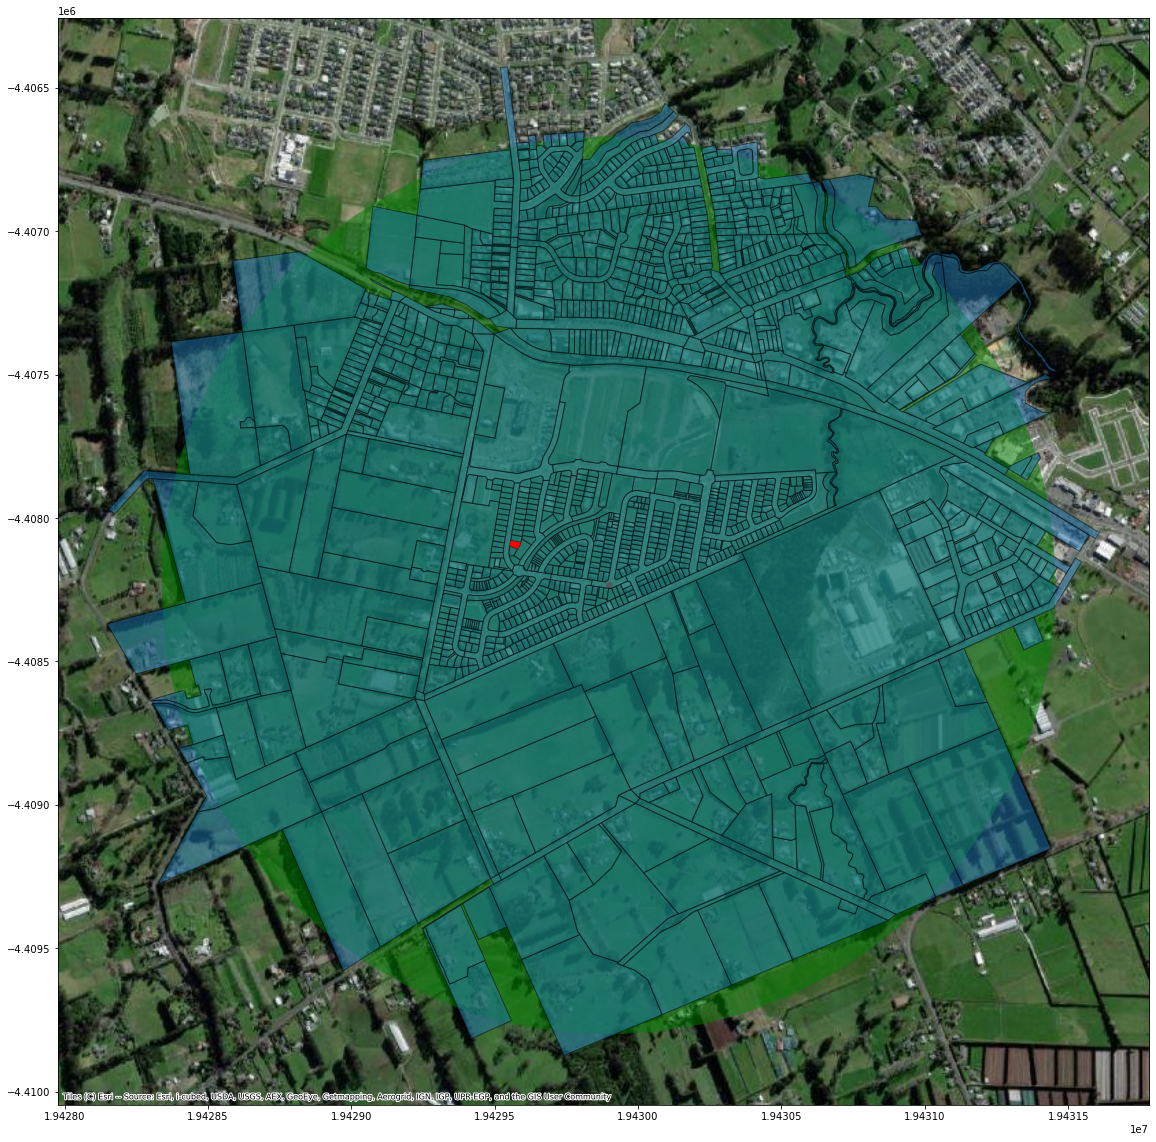

In [23]:
indices_in_range = parcel_tree.query_ball_point([sample.centroid.iloc[0].x, sample.centroid.iloc[0].y], 1250)
ax = sample.to_crs(epsg=3857).plot(color="red", alpha=1)
sample.buffer(1250).to_crs(epsg=3857).plot(ax=ax, alpha=.5, color="green")
potential_matches = parcels.iloc[indices_in_range]
potential_matches.to_crs(epsg=3857).plot(ax=ax, alpha=.5, edgecolor="black")
potential_matches[potential_matches.addresses.str.contains(sample.number_name.iloc[0], na=False, regex=False)].to_crs(epsg=3857).plot(ax=ax, color="red")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

In [24]:
def find_match_in_range(row):
    indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], 1250)
    potential_matches = parcels.iloc[indices_in_range]
    match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
    if len(match):
        row.LINZ_parcel_ID = match.index[0]
        row.addresses = match.addresses.iloc[0]
        row.full_addresses = match.full_addresses.iloc[0]
        row.LINZ_MATCH_CODE = 2
    return row
matches = df[
    ~pd.isna(df.number_name) &
    pd.isna(df["LINZ_MATCH_CODE"]) &
    df.number_name.isin(addresses.address_number_name)].progress_apply(find_match_in_range, axis=1)

  0%|          | 0/41249 [00:00<?, ?it/s]

In [25]:
matches

OBS              CONSENT_DATE                MARCH_YEAR  \
3       227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4       227902  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
6       227911  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
7       227912  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
9       227954  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...        ...                       ...                       ...   
207198  151375  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207203  151370  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207205  151368  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207208  151365  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207223  151350  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                                 ADDRESS_1     ADDRESS_2         ADDRESS_3  \
3                         56 VINISTRA ROAD        Huapai          Auckland   
4                         77 VINISTRA ROAD        Huapai          Auckland   
6       753A COATESVILLE-RIVERHEAD HIGHWAY     Riverhead          Auckland   
7                          21 DIAMOND LANE     Riverhead          Auckland   
9                            60 CLARK ROAD   Hobsonville          Auckland   
...                                    ...           ...               ...   
207198                                 20A   HOLBROOK ST          AVONDALE   
207203                                  5B  COMMODORE DR          LYNFIELD   
207205                                  54     ELLIS AVE     MOUNT ROSKILL   
207208                                  1B     WAIRUA RD           REMUERA   
207223                                 55B   PANORAMA RD  MOUNT WELLINGTON   

                      LB_Name  \
3                      Rodney   
4                      Rodney   
6                      Rodney   
7                      Rodney   
9               Upper Harbour   
...                       ...   
207198                   Whau   
207203             Puketapapa   
207205             Puketapapa   
207208                 Orakei   
207223  Maungakiekie - Tamaki   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
3                                                  Houses                1111   
4                                                  Houses                1111   
6                               Non-building construction                3111   
7                                          Farm buildings                2711   
9                                                  Houses                1111   
...                                                   ...                 ...   
207198  New (and pre-built) house, unit, bach, crib, b...                1100   
207203  New (and pre-built) house, unit, bach, crib, b...                1100   
207205  New (and pre-built) house, unit, bach, crib, b...                1100   
207208  New (and pre-built) house, unit, bach, crib, b...                1100   
207223  New (and pre-built) house, unit, bach, crib, b...                1100   

        FLOOR_AREA     VALUE  BUILDINGS Building_Type_Group Residential_Type  \
3            179.0       NaN          1         Residential         Detached   
4            180.0       NaN          1         Residential         Detached   
6              0.0       NaN          1               Other              NaN   
7            313.0       NaN          1               Other              NaN   
9            195.0       NaN          1         Residential         Detached   
...            ...       ...        ...                 ...              ...   
207198       241.0  350000.0          1         Residential         Detached   
207203       160.0  250000.0          1         Residential         Detached   
207205       158.0  268000.0          1         Residential         Detached   
207208       127.0  400000.0          1         Residential    

In [26]:
df.update(matches)
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0    127623
NaN     43953
2.0     35650
Name: LINZ_MATCH_CODE, dtype: int64

In [27]:
df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)]

OBS              CONSENT_DATE                MARCH_YEAR  \
6       227911.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
9       227954.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
18      228723.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
21      228822.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
22      228824.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...          ...                       ...                       ...   
207144  151429.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207145  151428.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207146  151427.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207147  151426.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207148  151425.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                                 ADDRESS_1     ADDRESS_2   ADDRESS_3  \
6       753A COATESVILLE-RIVERHEAD HIGHWAY     Riverhead    Auckland   
9                            60 CLARK ROAD   Hobsonville    Auckland   
18               344 FLAT BUSH SCHOOL ROAD     FLAT BUSH    Auckland   
21                          149 GROVE ROAD      PAPAKURA    Auckland   
22                          173 GROVE ROAD      PAPAKURA    Auckland   
...                                    ...           ...         ...   
207144                                  62  BIRDWOOD AVE  PAPATOETOE   
207145                                  62  BIRDWOOD AVE  PAPATOETOE   
207146                                  62  BIRDWOOD AVE  PAPATOETOE   
207147                                  62  BIRDWOOD AVE  PAPATOETOE   
207148                                  62  BIRDWOOD AVE  PAPATOETOE   

                     LB_Name  \
6                     Rodney   
9              Upper Harbour   
18                    Howick   
21      Devonport - Takapuna   
22      Devonport - Takapuna   
...                      ...   
207144    Otara - Papatoetoe   
207145    Otara - Papatoetoe   
207146    Otara - Papatoetoe   
207147    Otara - Papatoetoe   
207148    Otara - Papatoetoe   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
6                               Non-building construction              3111.0   
9                                                  Houses              1111.0   
18                              Non-building construction              3111.0   
21                                                 Houses              1111.0   
22                                                 Houses              1111.0   
...                                                   ...                 ...   
207144  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207145  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207146  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207147  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207148  New (and pre-built) house, unit, bach, crib, b...              1100.0   

        FLOOR_AREA     VALUE  BUILDINGS Building_Type_Group Residential_Type  \
6              0.0       NaN        1.0               Other              NaN   
9            195.0       NaN        1.0         Residential         Detached   
18             0.0       NaN        1.0               Other              NaN   
21           100.0       NaN        1.0         Residential         Detached   
22           100.0       NaN        1.0         Residential         Detached   
...            ...       ...        ...                 ...              ...   
207144        95.0  295000.0        1.0         Residential         Detached   
207145       120.0  295000.0        1.0         Residential         Detached   
207146        81.0  295000.0        1.0         Residential         Detached   
207147        95.0  295000.0        1.0         Residential         Detached   
207148        81.0  295000.0        1.0      

In [29]:
%%time
number_name_lookup = {}
for parcel_id, addresses in parcels.addresses[~pd.isna(parcels.addresses)].iteritems():
    for address in addresses:
        if address not in number_name_lookup:
            number_name_lookup[address] = []
        number_name_lookup[address].append(parcel_id)

CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.77 s


In [31]:
%%time
def find_text_match(row):
    matching_ids = number_name_lookup.get(row.number_name)
    if len(matching_ids):
        match = parcels.loc[matching_ids]
        closest_parcel_id = match.distance(row.geometry).idxmin()
        row.LINZ_parcel_ID = closest_parcel_id
        row.addresses = match.addresses[closest_parcel_id]
        row.full_addresses = match.full_addresses[closest_parcel_id]
        row.LINZ_MATCH_CODE = 3
    return row
matches = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(number_name_lookup.keys())].progress_apply(find_text_match, axis=1)
df.update(matches)
df.LINZ_MATCH_CODE.value_counts(dropna=False)

  0%|          | 0/5599 [00:00<?, ?it/s]

CPU times: user 29.7 s, sys: 378 ms, total: 30.1 s
Wall time: 29.8 s


1.0    127623
NaN     38354
2.0     35650
3.0      5599
Name: LINZ_MATCH_CODE, dtype: int64

In [32]:
df.Ranged_Address_indicator = df.Ranged_Address_indicator.astype(bool)

In [33]:
maybe_subdivision = df[df.number_name.str.contains("/") & pd.isna(df.LINZ_MATCH_CODE) & ~df.Ranged_Address_indicator]
maybe_subdivision

OBS              CONSENT_DATE                MARCH_YEAR  \
10342   212327.0  Mar 01, 2020 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
17380   200118.0  Jul 01, 2019 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
17381   200119.0  Jul 01, 2019 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
28789   182824.0  Jul 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   
31969   178214.0  Mar 01, 2018 12:00:00 AM  Mar 01, 2018 12:00:00 AM   
...          ...                       ...                       ...   
205072   78099.0  Feb 01, 2002 12:00:00 AM  Apr 01, 2002 12:00:00 AM   
205580  148687.0  Jan 01, 2014 12:00:00 AM  Mar 01, 2014 12:00:00 AM   
206204  150759.0  May 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
206234  150729.0  May 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
206699  151875.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                     ADDRESS_1     ADDRESS_2   ADDRESS_3  \
10342     27033/1 Railway Land       Panmure    Auckland   
17380   57F/3 FOREST HILL ROAD     Henderson    Auckland   
17381   57F/1 FOREST HILL ROAD     Henderson    Auckland   
28789     1/334 GLENBROOK ROAD      PUKEKOHE    Auckland   
31969        1/9 Willis Street        Torbay    Auckland   
...                        ...           ...         ...   
205072                    2/40     ELLIS AVE  MT ROSKILL   
205580                    2/76  GLAMORGAN DR      TORBAY   
206204                    2/55      ARAWA ST         NaN   
206234                   3B/12     SEAWAY RD         NaN   
206699                   2/42A    SEAVIEW RD  CASTOR BAY   

                      LB_Name  \
10342   Maungakiekie - Tamaki   
17380      Henderson - Massey   
17381      Henderson - Massey   
28789                Franklin   
31969       Hibiscus and Bays   
...                       ...   
205072             Puketapapa   
205580      Hibiscus and Bays   
206204                   Whau   
206234               Franklin   
206699   Devonport - Takapuna   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
10342                           Non-building construction              3111.0   
17380                                              Houses              1111.0   
17381                                              Houses              1111.0   
28789                                              Houses              1111.0   
31969                                              Houses              1111.0   
...                                                   ...                 ...   
205072  New (and pre-built) house, unit, bach, crib, b...              1100.0   
205580  New (and pre-built) house, unit, bach, crib, b...              1100.0   
206204  New (and pre-built) house, unit, bach, crib, b...              1100.0   
206234  New (and pre-built) house, unit, bach, crib, b...              1100.0   
206699  New (and pre-built) house, unit, bach, crib, b...              1100.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
10342          0.0    45000.0        1.0               Other              NaN   
17380        139.0   287000.0        1.0         Residential         Detached   
17381        139.0   287000.0        4.0         Residential         Detached   
28789        649.0  1000000.0        1.0         Residential         Detached   
31969        205.0   850000.0        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
205072       262.0   200000.0        2.0         Residential         Detached   
205580       247.0   370500.0        1.0         Residential         Detached   
206204       225.0   320000.0        1.0         Residential         Detached   
206234        23.0    45000.0        1.0         Residential         Detached   
206699       377.0   590000.0        1.0         Residential         Detached   

       Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR  \
10342 

In [34]:
maybe_subdivision.number_name = maybe_subdivision.number_name.str.split("/").str[-1]

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [35]:
def check_match(row):
    if row.number_name in row.addresses:
        return 1
    return np.nan
match = maybe_subdivision[~pd.isna(maybe_subdivision.addresses)].apply(check_match, axis=1)
maybe_subdivision.LINZ_MATCH_CODE = match
match.value_counts(dropna=False)

1.0    730
NaN    692
dtype: int64

In [36]:
matches = maybe_subdivision[
    pd.isna(match) &
    maybe_subdivision.number_name.isin(number_name_lookup.keys())].progress_apply(find_match_in_range, axis=1)

  0%|          | 0/286 [00:00<?, ?it/s]

In [37]:
matches

OBS              CONSENT_DATE                MARCH_YEAR  \
17380   200118.0  Jul 01, 2019 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
17381   200119.0  Jul 01, 2019 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
31969   178214.0  Mar 01, 2018 12:00:00 AM  Mar 01, 2018 12:00:00 AM   
43284   166898.0  Aug 01, 2016 12:00:00 AM  Mar 01, 2017 12:00:00 AM   
43991   166191.0  Jul 01, 2016 12:00:00 AM  Mar 01, 2017 12:00:00 AM   
47378   162630.0  Feb 01, 2016 12:00:00 AM  Mar 01, 2016 12:00:00 AM   
50228   159952.0  Sep 01, 2015 12:00:00 AM  Mar 01, 2016 12:00:00 AM   
51966   156427.0  Jun 01, 2015 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
54403   154547.0  Feb 01, 2015 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
55857   153519.0  Nov 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
55960   153414.0  Oct 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
57061   152311.0  Aug 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
60178   139281.0  Apr 01, 2012 12:00:00 AM  Mar 01, 2012 12:00:00 AM   
61986   142338.0  Nov 01, 2012 12:00:00 AM  Mar 01, 2012 12:00:00 AM   
65068   147764.0  Nov 01, 2013 12:00:00 AM  Mar 01, 2013 12:00:00 AM   
65429   144261.0  Apr 01, 2013 12:00:00 AM  Mar 01, 2013 12:00:00 AM   
67604    62398.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
67605    62397.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
67628    62374.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
67741    62261.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
67788    62214.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
67872    62130.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
68136    61839.0  Oct 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
69414    63574.0  Dec 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
69415    63573.0  Dec 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
69520    63468.0  Dec 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
69620    63367.0  Dec 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
69813    63174.0  Nov 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
70661    60061.0  Jul 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
70694    60028.0  Jul 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
71255    59465.0  Jun 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
71320    59400.0  Jun 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
71956    57887.0  Apr 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
72716    57121.0  Mar 01, 1999 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
72757    57080.0  Mar 01, 1999 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
73873    58439.0  May 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
73878    58434.0  May 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
74167    58145.0  May 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
74207    58105.0  May 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
74667    56146.0  Feb 01, 1999 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
75032    55781.0  Feb 01, 1999 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
76006    54805.0  Dec 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
76080    54731.0  Dec 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
76600    54210.0  Nov 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
76713    54097.0  Nov 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
77008    60535.0  Aug 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
77098    60445.0  Aug 01, 1999 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
77318    54036.0  Nov 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
77949    53379.0  Sep 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
78523    52794.0  Aug 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
78577    52740.0  Aug 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
78797    52520.0  Aug 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
78806    52511.0  Aug 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
78986    52325.0  Jul 01, 1998 12:00:00 AM  Apr 01, 1999 12:00:00 AM   
79018    52293.0  Jul 01, 1998 12:00:00 AM  Apr 01, 1

In [38]:
maybe_subdivision.update(matches)
maybe_subdivision.LINZ_MATCH_CODE.value_counts(dropna=False)

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


1.0    730
NaN    643
2.0    223
Name: LINZ_MATCH_CODE, dtype: int64

In [39]:
matches = maybe_subdivision[pd.isna(maybe_subdivision["LINZ_MATCH_CODE"]) & maybe_subdivision.number_name.isin(number_name_lookup.keys())].progress_apply(find_text_match, axis=1)
maybe_subdivision.update(matches)
maybe_subdivision.LINZ_MATCH_CODE.value_counts(dropna=False)

  0%|          | 0/147 [00:00<?, ?it/s]

1.0    730
NaN    496
2.0    223
3.0    147
Name: LINZ_MATCH_CODE, dtype: int64

In [40]:
maybe_subdivision

OBS              CONSENT_DATE                MARCH_YEAR  \
10342   212327.0  Mar 01, 2020 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
17380   200118.0  Jul 01, 2019 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
17381   200119.0  Jul 01, 2019 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
28789   182824.0  Jul 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   
31969   178214.0  Mar 01, 2018 12:00:00 AM  Mar 01, 2018 12:00:00 AM   
...          ...                       ...                       ...   
205072   78099.0  Feb 01, 2002 12:00:00 AM  Apr 01, 2002 12:00:00 AM   
205580  148687.0  Jan 01, 2014 12:00:00 AM  Mar 01, 2014 12:00:00 AM   
206204  150759.0  May 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
206234  150729.0  May 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
206699  151875.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                     ADDRESS_1     ADDRESS_2   ADDRESS_3  \
10342     27033/1 Railway Land       Panmure    Auckland   
17380   57F/3 FOREST HILL ROAD     Henderson    Auckland   
17381   57F/1 FOREST HILL ROAD     Henderson    Auckland   
28789     1/334 GLENBROOK ROAD      PUKEKOHE    Auckland   
31969        1/9 Willis Street        Torbay    Auckland   
...                        ...           ...         ...   
205072                    2/40     ELLIS AVE  MT ROSKILL   
205580                    2/76  GLAMORGAN DR      TORBAY   
206204                    2/55      ARAWA ST         NaN   
206234                   3B/12     SEAWAY RD         NaN   
206699                   2/42A    SEAVIEW RD  CASTOR BAY   

                      LB_Name  \
10342   Maungakiekie - Tamaki   
17380      Henderson - Massey   
17381      Henderson - Massey   
28789                Franklin   
31969       Hibiscus and Bays   
...                       ...   
205072             Puketapapa   
205580      Hibiscus and Bays   
206204                   Whau   
206234               Franklin   
206699   Devonport - Takapuna   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
10342                           Non-building construction              3111.0   
17380                                              Houses              1111.0   
17381                                              Houses              1111.0   
28789                                              Houses              1111.0   
31969                                              Houses              1111.0   
...                                                   ...                 ...   
205072  New (and pre-built) house, unit, bach, crib, b...              1100.0   
205580  New (and pre-built) house, unit, bach, crib, b...              1100.0   
206204  New (and pre-built) house, unit, bach, crib, b...              1100.0   
206234  New (and pre-built) house, unit, bach, crib, b...              1100.0   
206699  New (and pre-built) house, unit, bach, crib, b...              1100.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
10342          0.0    45000.0        1.0               Other              NaN   
17380        139.0   287000.0        1.0         Residential         Detached   
17381        139.0   287000.0        4.0         Residential         Detached   
28789        649.0  1000000.0        1.0         Residential         Detached   
31969        205.0   850000.0        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
205072       262.0   200000.0        2.0         Residential         Detached   
205580       247.0   370500.0        1.0         Residential         Detached   
206204       225.0   320000.0        1.0         Residential         Detached   
206234        23.0    45000.0        1.0         Residential         Detached   
206699       377.0   590000.0        1.0         Residential         Detached   

       Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR  \
10342 

In [41]:
maybe_subdivision.LINZ_MATCH_CODE = maybe_subdivision.LINZ_MATCH_CODE.replace({1: 4, 2: 5, 3: 6})
maybe_subdivision.LINZ_MATCH_CODE.value_counts()

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


4.0    730
5.0    223
6.0    147
Name: LINZ_MATCH_CODE, dtype: int64

In [42]:
df.update(maybe_subdivision)

In [43]:
maybe_subdivision = df[
    df.number_name.str.contains("[0-9][a-zA-Z] ") &
    pd.isna(df.LINZ_MATCH_CODE) &
    (df.Ranged_Address_indicator == False)
]
maybe_subdivision

OBS              CONSENT_DATE                MARCH_YEAR  \
362     228135.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
466     228408.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
604     228653.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
605     228654.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
606     228655.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...          ...                       ...                       ...   
207088  151485.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207113  151460.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207116  151457.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207120  151453.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207154  151419.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                ADDRESS_1    ADDRESS_2     ADDRESS_3            LB_Name  \
362     31F FRASER AVENUE    Northcote      Auckland          Kaipatiki   
466         2A TRURO ROAD  Sandringham      Auckland      Albert - Eden   
604     125C MURPHYS ROAD    Flat Bush      Auckland             Howick   
605     125C MURPHYS ROAD    Flat Bush      Auckland             Howick   
606     125C MURPHYS ROAD    Flat Bush      Auckland             Howick   
...                   ...          ...           ...                ...   
207088               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207113               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207116               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207120               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207154               253S  BUCKLAND RD  MANGERE EAST  Mangere - Otahuhu   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
362                             Non-building construction              3111.0   
466                                            Apartments              1121.0   
604         Townhouses, flats, units, and other dwellings              1129.0   
605         Townhouses, flats, units, and other dwellings              1129.0   
606         Townhouses, flats, units, and other dwellings              1129.0   
...                                                   ...                 ...   
207088  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207113  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207116  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207120  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207154              New Schools - excludes school hostels              1431.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
362            0.0        NaN        1.0               Other              NaN   
466            0.0        NaN        0.0         Residential         Attached   
604           98.0        NaN        1.0         Residential         Attached   
605            0.0        NaN        0.0         Residential         Attached   
606            0.0        NaN        0.0         Residential         Attached   
...            ...        ...        ...                 ...              ...   
207088       147.0   183000.0        1.0         Residential         Detached   
207113       151.0   215000.0        1.0         Residential         Detached   
207116       154.0   198000.0        1.0         Residential         Detached   
207120       154.0   198000.0        1.0         Residential         Detached   
207154       685.0  2362000.0        1.0               Other              NaN   

       Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR  \
362               NaN               NaN           2014.0  364900.0  2013.0   
466               NaN               NaN           2014.0  537200.0  2013.0   
604               NaN               NaN           2014.0  713501.0 

In [44]:
def strip_char(s):
    number, name = s.split()
    number = "".join([c for c in number if c.isnumeric()])
    return number + " " + name
maybe_subdivision.number_name = maybe_subdivision.number_name.apply(strip_char)

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [45]:
def check_match(row):
    if row.number_name in row.addresses:
        return 1
    return np.nan
match = maybe_subdivision[~pd.isna(maybe_subdivision.addresses)].apply(check_match, axis=1)
maybe_subdivision.LINZ_MATCH_CODE = match
match.value_counts(dropna=False)

NaN    924
1.0    699
dtype: int64

In [46]:
matches = maybe_subdivision[
    pd.isna(match) &
    maybe_subdivision.number_name.isin(number_name_lookup.keys())].progress_apply(find_match_in_range, axis=1)

  0%|          | 0/611 [00:00<?, ?it/s]

In [47]:
maybe_subdivision.update(matches)
maybe_subdivision.LINZ_MATCH_CODE.value_counts(dropna=False)

NaN    795
1.0    699
2.0    465
Name: LINZ_MATCH_CODE, dtype: int64

In [48]:
matches = maybe_subdivision[pd.isna(maybe_subdivision["LINZ_MATCH_CODE"]) & maybe_subdivision.number_name.isin(number_name_lookup.keys())].progress_apply(find_text_match, axis=1)
maybe_subdivision.update(matches)
maybe_subdivision.LINZ_MATCH_CODE.value_counts(dropna=False)

  0%|          | 0/353 [00:00<?, ?it/s]

1.0    699
2.0    465
NaN    442
3.0    353
Name: LINZ_MATCH_CODE, dtype: int64

In [49]:
maybe_subdivision

OBS              CONSENT_DATE                MARCH_YEAR  \
362     228135.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
466     228408.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
604     228653.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
605     228654.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
606     228655.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...          ...                       ...                       ...   
207088  151485.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207113  151460.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207116  151457.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207120  151453.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207154  151419.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                ADDRESS_1    ADDRESS_2     ADDRESS_3            LB_Name  \
362     31F FRASER AVENUE    Northcote      Auckland          Kaipatiki   
466         2A TRURO ROAD  Sandringham      Auckland      Albert - Eden   
604     125C MURPHYS ROAD    Flat Bush      Auckland             Howick   
605     125C MURPHYS ROAD    Flat Bush      Auckland             Howick   
606     125C MURPHYS ROAD    Flat Bush      Auckland             Howick   
...                   ...          ...           ...                ...   
207088               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207113               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207116               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207120               398S  WEYMOUTH RD      WEYMOUTH           Manurewa   
207154               253S  BUCKLAND RD  MANGERE EAST  Mangere - Otahuhu   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
362                             Non-building construction              3111.0   
466                                            Apartments              1121.0   
604         Townhouses, flats, units, and other dwellings              1129.0   
605         Townhouses, flats, units, and other dwellings              1129.0   
606         Townhouses, flats, units, and other dwellings              1129.0   
...                                                   ...                 ...   
207088  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207113  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207116  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207120  New (and pre-built) house, unit, bach, crib, b...              1100.0   
207154              New Schools - excludes school hostels              1431.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
362            0.0        NaN        1.0               Other              NaN   
466            0.0        NaN        0.0         Residential         Attached   
604           98.0        NaN        1.0         Residential         Attached   
605            0.0        NaN        0.0         Residential         Attached   
606            0.0        NaN        0.0         Residential         Attached   
...            ...        ...        ...                 ...              ...   
207088       147.0   183000.0        1.0         Residential         Detached   
207113       151.0   215000.0        1.0         Residential         Detached   
207116       154.0   198000.0        1.0         Residential         Detached   
207120       154.0   198000.0        1.0         Residential         Detached   
207154       685.0  2362000.0        1.0               Other              NaN   

       Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR  \
362               NaN               NaN           2014.0  364900.0  2013.0   
466               NaN               NaN           2014.0  537200.0  2013.0   
604               NaN               NaN           2014.0  713501.0 

In [50]:
maybe_subdivision.LINZ_MATCH_CODE = maybe_subdivision.LINZ_MATCH_CODE.replace({1: 4, 2: 5, 3: 6})
maybe_subdivision.LINZ_MATCH_CODE.value_counts()

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


4.0    699
5.0    465
6.0    353
Name: LINZ_MATCH_CODE, dtype: int64

In [51]:
df.update(maybe_subdivision)

In [52]:
%%time
distances = df[~pd.isna(df.LINZ_parcel_ID)].distance(parcels.loc[df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]], align=False)
distances

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.64 s


0           0.000000
1           0.000000
2           0.000000
3         272.107738
4         302.608731
             ...    
207221      0.000000
207222      0.000000
207223     34.221509
207224      0.000000
207225      0.000000
Length: 207054, dtype: float64

In [53]:
distances[distances>0].describe()

count     42437.000000
mean       2382.699198
std        7915.549676
min           0.000062
25%           9.451613
50%          27.518422
75%         191.588766
max      100594.158959
dtype: float64

In [54]:
df["distance_to_parcel"] = distances

 Identify the LINZ parcel of the geo-coordinate of the consent. If the name of the road in the address of the LINZ parcel matches the road name of the address given in the consent dataset, set the parcel to be the LINZ parcel of the of geocoordinate of the consent. Set LINZ_MATCH_CODE = 7 and stop. If not, proceed to 8:

In [55]:
df[["number_name", "addresses"]]

number_name                                          addresses
0           398 pakiri                                                NaN
1          ahuroa road                                                NaN
2          upper orewa                                                NaN
3          56 vinistra                                      [56 vinistra]
4          77 vinistra                                      [77 vinistra]
...                ...                                                ...
207221  164-168 hobson  [37 cook, 1305/168 hobson, 1301/168 hobson, 16...
207222     464 remuera  [464 remuera, 2/464 remuera, 1/464 remuera, 3b...
207223    55b panorama                                     [55b panorama]
207224      67 customs  [67 customs, 8/67 customs, 7/67 customs, 4/67 ...
207225      67 customs  [67 customs, 8/67 customs, 7/67 customs, 4/67 ...

[207226 rows x 2 columns]

In [56]:
def check_street_match(row):
    if row.number_name and len(row.number_name)>1:
        street = row.number_name.split()[-1]
        if street in str(row.addresses):
            return 7
    return np.nan
street_matches = df[pd.isna(df.LINZ_MATCH_CODE)].progress_apply(check_street_match, axis=1)
display(street_matches.value_counts(dropna=False))
df.LINZ_MATCH_CODE.update(street_matches)

  0%|          | 0/35737 [00:00<?, ?it/s]

NaN    25328
7.0    10409
dtype: int64

Identify the LINZ parcel of the geo-coordinate of the consent and use this. Set LINZ_MATCH_CODE = 8 and stop. If there is no parcel under the geo-coordinate, go to step 9:

In [57]:
df.LINZ_MATCH_CODE[~pd.isna(df.LINZ_parcel_ID) & pd.isna(df.LINZ_MATCH_CODE)] = 8

/tmp/ipykernel_838276/8225981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.LINZ_MATCH_CODE[~pd.isna(df.LINZ_parcel_ID) & pd.isna(df.LINZ_MATCH_CODE)] = 8


Set LINZ_MATCH_CODE = 9. This indicates no match even with just the consent long-lat.

In [58]:
df.LINZ_MATCH_CODE = df.LINZ_MATCH_CODE.fillna(9)
df.LINZ_MATCH_CODE.value_counts()

1.0    127623
2.0     35650
8.0     25212
7.0     10409
3.0      5599
4.0      1429
5.0       688
6.0       500
9.0       116
Name: LINZ_MATCH_CODE, dtype: int64

In [59]:
df.LINZ_MATCH_CODE[df.Ranged_Address_indicator].value_counts()

7.0    3295
8.0    2199
1.0     392
2.0     388
3.0     103
9.0       1
Name: LINZ_MATCH_CODE, dtype: int64

MATCHING FOR RANGED ADDRESSES:
For ranged addresses, follow the same approach for each individual address, using the same geo-coordinate for each address in step 1. However, we set r in step 2 to a larger number in order to do a wider search. If no matches are found at step 2, but at least one match in the ranged address is found at step 1 or step 2, go to step 5. This avoids matching parcels that are far away from the rest of the group. Only if there is no match within the ranged addresses at either step 1 or step 2 do we proceed to step 3. 

We include an additional flag for each ranged address that indicates the best (i.e. lowest) LINZ_MATCH_CODE for that range. E.g. for a ranged address with five addresses, if at least one of them had LINZ_MATCH_CODE = 2, and all others were LINZ_MATCH_CODE > 2, then the best LINZ_MATCH_CODE would be 2. This is call LINZ_2ND_MATCH_CODE below.
Each address (in the ranged address set) is assigned its own unique LINZ parcel. Each parcel is then assigned the information given in 1 through 11 below. Because the parcels share the same consent ID, we can tell that the different parcels pertain to the same consent, thereby avoiding double counting. 

In [60]:
ranged = df[df.Ranged_Address_indicator & (df.LINZ_MATCH_CODE > 2)]
ranged

OBS              CONSENT_DATE                MARCH_YEAR  \
12      228134.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
13      228236.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
14      228263.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
15      228338.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
910     226714.0  Jan 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...          ...                       ...                       ...   
207053  151520.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207065  151508.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207216  151357.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207218  151355.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207221  151352.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                          ADDRESS_1         ADDRESS_2     ADDRESS_3  \
12                7-19 TONAR STREET         Northcote      Auckland   
13      74-80 Wellesley Street West  Auckland Central      Auckland   
14             469-471 Parnell Road           Parnell      Auckland   
15             17-19 TUHAERE STREET            Orakei      Auckland   
910        39-41 BRUCE MCLAREN ROAD         Henderson      Auckland   
...                             ...               ...           ...   
207053                          2-6      TITIRANGI RD      NEW LYNN   
207065                      433-435    HOBSONVILLE RD   HOBSONVILLE   
207216                         9-11         FENTON ST  EDEN TERRACE   
207218                    138A-138C         GOWING DR    MEADOWBANK   
207221                      164-168         HOBSON ST      AUCKLAND   

                   LB_Name                                 BUILDING_TYPE_NAME  \
12               Kaipatiki                                         Apartments   
13               Waitemata  Hotels, motels, and other short-term accommoda...   
14               Waitemata                          Non-building construction   
15                  Orakei                                             Houses   
910     Henderson - Massey      Townhouses, flats, units, and other dwellings   
...                    ...                                                ...   
207053                Whau                                          New Shops   
207065       Upper Harbour  New (and pre-built) house, unit, bach, crib, b...   
207216           Waitemata                                          New Flats   
207218              Orakei  New (and pre-built) house, unit, bach, crib, b...   
207221           Waitemata                                          New Flats   

        BUILDING_TYPE_CODE  FLOOR_AREA       VALUE  BUILDINGS  \
12                  1121.0      2905.0         NaN       29.0   
13                  2121.0         0.0         NaN        1.0   
14                  3111.0         0.0         NaN        1.0   
15                  1111.0       450.0         NaN        1.0   
910                 1129.0        28.0         NaN        1.0   
...                    ...         ...         ...        ...   
207053              1451.0         0.0  10100000.0        0.0   
207065              1100.0       206.0    288680.0        1.0   
207216              1200.0      3760.0   3000000.0       37.0   
207218              1100.0       214.0    390000.0        1.0   
207221              1200.0         0.0   3650000.0        0.0   

       Building_Type_Group Residential_Type Business_Group Business_Category  \
12             Residential         Attached            NaN               NaN   
13                Business              NaN        Group 2       Hospitality   
14                   Other              NaN            NaN               NaN   
15             Residential         Detached            NaN               NaN   
910            Residential         Attached            NaN               NaN   
...                    ...              ...            ...   

In [61]:
def parse_int(value):
    return int(''.join(filter(lambda c: c.isdigit(), value)))

def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)+1):
        yield chr(c)

def range_expand(r):
    """given a range r, like '20-23', expand the range on one side of the road, e.g. ['20', '21', '22', '23']"""
    if '/' in r:
        a, b = r.split('/')
        if "-" in a:
            r = a
            suffix = "/" + b
        else:
            r = b
            suffix = "/" + a
    else:
        suffix = ''
    r1, r2 = r.split('-')
    if r2 == "sep" or r2 == "":
        return [r1]
    if r2.isalpha():
        return [r1.replace(r1[-1], char) for char in char_range(r1[-1], r2)]
    r1 = parse_int(r1)
    r2 = parse_int(r2)
    if suffix:
        step = 1
    else:
        step = 2
    if r1 < r2:
        return [str(i) + suffix for i in range(r1, r2 + 1, step)]
    else:
        return [str(i) + suffix for i in range(r2, r1 + 1, step)]

corrections = {
    "1/ 231-235": "231-235 hinemoa",
    "2/ 16-18": "16-18 montgomery",
    "2/ 2-8": "2-8 matipo",
    "r 35-41": "35-41 birkenhead",
    "r 31-35": "31-35 cresta",
    "27 -": "27-31 victoria",
    "1 &": "2-1/96 bernleigh",
    "55121-23 morrison": "21-23 morrison",
    "1954-60 great": "1954-1960 great",
    "3-9 ": "3-9 faldo"
}
ranged.number_name = ranged.number_name.replace(corrections)

for r in ranged.number_name:
    e = None
    try:
        number, name = r.split()
        range_expanded = range_expand(number)
        assert len(range_expanded) > 0 and len(range_expanded) < 1000
    except Exception as e:
        print(f"Parsing of {r} failed: {e}")
        display(ranged[ranged.number_name == r])

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [62]:
for test_case in ['20-28', '1-5/32a', '53a-c']:
    print(f"{test_case}: {range_expand(test_case)}")

20-28: ['20', '22', '24', '26', '28']
1-5/32a: ['1/32a', '2/32a', '3/32a', '4/32a', '5/32a']
53a-c: ['53a', '53b', '53c']


In [63]:
%%time
expanded_ranged_addresses = []
for i, sample in tqdm(ranged.iterrows(), total=len(ranged)):
    # Expand this ranged address into it's own dataframe, with each number as it's own row
    number, name = sample.number_name.split()
    rows = []
    for n in range_expand(number):
        row = sample.copy()
        row.number_name = n + " " + name
        row["unique_id"] = f"{row.OBS}_{n}"
        rows.append(row)
    sample = pd.DataFrame(rows).set_index("unique_id")
    if not sample.index.is_unique:
        display(sample)
        raise

    # Step 1
    def check_match(row):
        if row.number_name in row.addresses:
            return 1
        return np.nan
    match = sample[~pd.isna(sample.number_name) & ~pd.isna(sample.addresses)].apply(check_match, axis=1)
    if len(match):
        sample["LINZ_MATCH_CODE"] = match
    else:
        sample["LINZ_MATCH_CODE"] = np.nan

    #However, we set r in step 2 to a larger number in order to do a wider search.

    def find_match_in_range(row):
        if str(row.geometry) == "nan":
            return row
        indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], 2000)
        potential_matches = parcels.iloc[indices_in_range]
        match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
        if len(match):
            row.LINZ_parcel_ID = match.index[0]
            row.addresses = match.addresses.iloc[0]
            row.full_addresses = match.full_addresses.iloc[0]
            row.LINZ_MATCH_CODE = 2
        return row
    matches = sample[
        ~pd.isna(sample.number_name) &
        pd.isna(sample["LINZ_MATCH_CODE"])].apply(find_match_in_range, axis=1)
    sample.update(matches)

    # If no matches are found at step 2, but at least one match in the ranged address is found at step 1 or step 2, stop and set LINZ_match_code to 10
    # This avoids matching parcels that are far away from the rest of the group
    if all(pd.isna(sample.LINZ_MATCH_CODE)): # all na here means no matches in step 1 or 2
        # Only if there is no match within the ranged addresses at either step 1 or step 2 do we proceed to step 3. 
        matches = sample[pd.isna(sample["LINZ_MATCH_CODE"]) & sample.number_name.isin(number_name_lookup.keys())].apply(find_text_match, axis=1)
        sample.update(matches)
        maybe_subdivision = sample[sample.number_name.str.contains("/") & pd.isna(sample.LINZ_MATCH_CODE)]
        if len(maybe_subdivision):
            maybe_subdivision.number_name = maybe_subdivision.number_name.str.split("/").str[-1]
            # step 1
            match = maybe_subdivision[~pd.isna(maybe_subdivision.addresses)].apply(check_match, axis=1)
            if len(match):
                maybe_subdivision["LINZ_MATCH_CODE"] = match
            else:
                maybe_subdivision["LINZ_MATCH_CODE"] = np.nan
            # step 2
            matches = maybe_subdivision[
                pd.isna(match) &
                maybe_subdivision.number_name.isin(number_name_lookup.keys())
            ].apply(find_match_in_range, axis=1)
            maybe_subdivision.update(matches)
            # step 3
            matches = maybe_subdivision[
                pd.isna(maybe_subdivision["LINZ_MATCH_CODE"]) & maybe_subdivision.number_name.isin(number_name_lookup.keys())
            ].apply(find_text_match, axis=1)
            maybe_subdivision.update(matches)
            maybe_subdivision.LINZ_MATCH_CODE = maybe_subdivision.LINZ_MATCH_CODE.replace({1: 4, 2: 5, 3: 6})
            sample.update(maybe_subdivision)
        maybe_subdivision = sample[
            sample.number_name.str.contains("[0-9][a-zA-Z] ") &
            pd.isna(sample.LINZ_MATCH_CODE)
        ]
        if len(maybe_subdivision):
            maybe_subdivision.number_name = maybe_subdivision.number_name.apply(strip_char)
            # step 1
            match = maybe_subdivision[~pd.isna(maybe_subdivision.addresses)].apply(check_match, axis=1)
            if len(match):
                maybe_subdivision["LINZ_MATCH_CODE"] = match
            else:
                maybe_subdivision["LINZ_MATCH_CODE"] = np.nan
            # step 2
            matches = maybe_subdivision[
                pd.isna(match) &
                maybe_subdivision.number_name.isin(number_name_lookup.keys())
            ].apply(find_match_in_range, axis=1)
            maybe_subdivision.update(matches)
            # step 3
            matches = maybe_subdivision[
                pd.isna(maybe_subdivision["LINZ_MATCH_CODE"]) & maybe_subdivision.number_name.isin(number_name_lookup.keys())
            ].apply(find_text_match, axis=1)
            maybe_subdivision.update(matches)
            maybe_subdivision.LINZ_MATCH_CODE = maybe_subdivision.LINZ_MATCH_CODE.replace({1: 4, 2: 5, 3: 6})
            sample.update(maybe_subdivision)

        if all(pd.isna(sample.LINZ_MATCH_CODE)):
            street_matches = sample[pd.isna(sample.LINZ_MATCH_CODE)].apply(check_street_match, axis=1)
            sample.LINZ_MATCH_CODE.update(street_matches)
            sample.loc[~pd.isna(sample.LINZ_parcel_ID) & pd.isna(sample.LINZ_MATCH_CODE), "LINZ_MATCH_CODE"] = 8
            sample.LINZ_MATCH_CODE = sample.LINZ_MATCH_CODE.fillna(9)
        else:
            sample.LINZ_MATCH_CODE = sample.LINZ_MATCH_CODE.fillna(10)
    else:
        sample.LINZ_MATCH_CODE = sample.LINZ_MATCH_CODE.fillna(10)
    #We include an additional flag for each ranged address that indicates the best (i.e. lowest) LINZ_MATCH_CODE for that range.
    #E.g. for a ranged address with five addresses, if at least one of them had LINZ_MATCH_CODE = 2,
    #and all others were LINZ_MATCH_CODE > 2, then the best LINZ_MATCH_CODE would be 2. This is call LINZ_2ND_MATCH_CODE below.
    # Each address (in the ranged address set) is assigned its own unique LINZ parcel.
    # Each parcel is then assigned the information given in 1 through 11 below.
    # Because the parcels share the same consent ID, we can tell that the different parcels pertain to the same consent, thereby avoiding double counting. 
    sample["LINZ_2ND_MATCH_CODE"] = sample.LINZ_MATCH_CODE.min()
    expanded_ranged_addresses.append(sample)

  0%|          | 0/5598 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<timed exec>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/pandas/core/frame.py:7511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

CPU times: user 23min 9s, sys: 3.76 s, total: 23min 13s
Wall time: 23min 9s


In [64]:
df = df.drop(ranged.index)
df = pd.concat([df] + expanded_ranged_addresses)
df

OBS              CONSENT_DATE                MARCH_YEAR  \
0             227614.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
1             227656.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
2             227796.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
3             227896.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4             227902.0  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...                ...                       ...                       ...   
151357.0_11   151357.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
151355.0_138  151355.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
151352.0_164  151352.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
151352.0_166  151352.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
151352.0_168  151352.0  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                          ADDRESS_1    ADDRESS_2     ADDRESS_3    LB_Name  \
0             398 PAKIRI BLOCK ROAD     Tomarata      Auckland     Rodney   
1                       Ahuroa Road        Puhoi      Auckland     Rodney   
2                  Upper Orewa Road  Upper Orewa      Auckland     Rodney   
3                  56 VINISTRA ROAD       Huapai      Auckland     Rodney   
4                  77 VINISTRA ROAD       Huapai      Auckland     Rodney   
...                             ...          ...           ...        ...   
151357.0_11                    9-11    FENTON ST  EDEN TERRACE  Waitemata   
151355.0_138              138A-138C    GOWING DR    MEADOWBANK     Orakei   
151352.0_164                164-168    HOBSON ST      AUCKLAND  Waitemata   
151352.0_166                164-168    HOBSON ST      AUCKLAND  Waitemata   
151352.0_168                164-168    HOBSON ST      AUCKLAND  Waitemata   

                                             BUILDING_TYPE_NAME  \
0                                                        Houses   
1                                     Non-building construction   
2                 Townhouses, flats, units, and other dwellings   
3                                                        Houses   
4                                                        Houses   
...                                                         ...   
151357.0_11                                           New Flats   
151355.0_138  New (and pre-built) house, unit, bach, crib, b...   
151352.0_164                                          New Flats   
151352.0_166                                          New Flats   
151352.0_168                                          New Flats   

              BUILDING_TYPE_CODE  FLOOR_AREA      VALUE  BUILDINGS  \
0                         1111.0       231.0        NaN        1.0   
1                         3111.0         0.0        NaN        1.0   
2                         1129.0       260.0        NaN        2.0   
3                         1111.0       179.0        NaN        1.0   
4                         1111.0       180.0        NaN        1.0   
...                          ...         ...        ...        ...   
151357.0_11               1200.0      3760.0  3000000.0       37.0   
151355.0_138              1100.0       214.0   390000.0        1.0   
151352.0_164              1200.0         0.0  3650000.0        0.0   
151352.0_166              1200.0         0.0  3650000.0        0.0   
151352.0_168              1200.0         0.0  3650000.0        0.0   

             Building_Type_Group Residential_Type Business_Group  \
0                    Residential         Detached            NaN   
1                          Other              NaN            NaN   
2                    Residential         Attached            NaN   
3                    Residential         Detached            NaN   
4                    Residential         Detached            NaN   
...                          ...              ...            ...   
151357.0_11          Residential   

In [65]:
df.LINZ_MATCH_CODE[df.Ranged_Address_indicator].value_counts(dropna=False)

2.0     15548
10.0    13305
1.0      3906
3.0      2772
8.0      2263
7.0       804
5.0       125
4.0        45
6.0        35
Name: LINZ_MATCH_CODE, dtype: int64

In [66]:
df.LINZ_2ND_MATCH_CODE[df.Ranged_Address_indicator].value_counts(dropna=False)

2.0    16078
1.0    14831
3.0     3850
8.0     2263
7.0      804
NaN      780
5.0      123
4.0       43
6.0       31
Name: LINZ_2ND_MATCH_CODE, dtype: int64

In [67]:
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0     131137
2.0      50810
8.0      25276
10.0     13305
3.0       8268
7.0       7918
4.0       1474
5.0        813
6.0        535
9.0        115
Name: LINZ_MATCH_CODE, dtype: int64

In [68]:
%%time
df = df.reset_index()
distances = df[~pd.isna(df.LINZ_parcel_ID)].distance(parcels.loc[df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]], align=False)
display(distances)
display(distances[distances>0].describe())

<timed exec>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:2193



0           0.000000
1           0.000000
2           0.000000
3         272.107738
4         302.608731
             ...    
239646      0.000000
239647     12.431048
239648      0.000000
239649      0.000000
239650      0.000000
Length: 239480, dtype: float64

count     60541.000000
mean       2816.291424
std        8732.070907
min           0.000062
25%          11.051819
50%          40.195130
75%         237.302443
max      100594.158959
dtype: float64

CPU times: user 2.41 s, sys: 240 ms, total: 2.65 s
Wall time: 2.65 s


In [69]:
df["distance_to_parcel"] = distances

In [70]:
df[(df.LINZ_MATCH_CODE == 3) & (df.distance_to_parcel > 10000)]

index       OBS              CONSENT_DATE  \
9                  9  227954.0  Feb 01, 2021 12:00:00 AM   
17                21  228822.0  Feb 01, 2021 12:00:00 AM   
18                22  228824.0  Feb 01, 2021 12:00:00 AM   
19                23  228825.0  Feb 01, 2021 12:00:00 AM   
22                26  228828.0  Feb 01, 2021 12:00:00 AM   
...              ...       ...                       ...   
239433    77988.0_33   77988.0  Feb 01, 2002 12:00:00 AM   
239434    77988.0_35   77988.0  Feb 01, 2002 12:00:00 AM   
239435    77988.0_37   77988.0  Feb 01, 2002 12:00:00 AM   
239588  150655.0_143  150655.0  May 01, 2014 12:00:00 AM   
239589  150655.0_145  150655.0  May 01, 2014 12:00:00 AM   

                      MARCH_YEAR           ADDRESS_1       ADDRESS_2  \
9       Mar 01, 2020 12:00:00 AM       60 CLARK ROAD     Hobsonville   
17      Mar 01, 2020 12:00:00 AM      149 GROVE ROAD        PAPAKURA   
18      Mar 01, 2020 12:00:00 AM      173 GROVE ROAD        PAPAKURA   
19      Mar 01, 2020 12:00:00 AM  26 KAIRAKAU STREET        PAPAKURA   
22      Mar 01, 2020 12:00:00 AM      139 GROVE ROAD        PAPAKURA   
...                          ...                 ...             ...   
239433  Apr 01, 2002 12:00:00 AM               29-37   THE CONCOURSE   
239434  Apr 01, 2002 12:00:00 AM               29-37   THE CONCOURSE   
239435  Apr 01, 2002 12:00:00 AM               29-37   THE CONCOURSE   
239588  Mar 01, 2015 12:00:00 AM             143-157  GREAT SOUTH RD   
239589  Mar 01, 2015 12:00:00 AM             143-157  GREAT SOUTH RD   

            ADDRESS_3               LB_Name  \
9            Auckland         Upper Harbour   
17           Auckland  Devonport - Takapuna   
18           Auckland  Devonport - Takapuna   
19           Auckland                Rodney   
22           Auckland  Devonport - Takapuna   
...               ...                   ...   
239433  LINCOLN NORTH      Waitakere Ranges   
239434  LINCOLN NORTH      Waitakere Ranges   
239435  LINCOLN NORTH      Waitakere Ranges   
239588            NaN              Papakura   
239589            NaN              Papakura   

                           BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  FLOOR_AREA  \
9                                      Houses              1111.0       195.0   
17                                     Houses              1111.0       100.0   
18                                     Houses              1111.0       100.0   
19                                     Houses              1111.0       113.0   
22                                     Houses              1111.0       133.0   
...                                       ...                 ...         ...   
239433  New Schools - excludes school hostels              1431.0        86.0   
239434  New Schools - excludes school hostels              1431.0        86.0   
239435  New Schools - excludes school hostels              1431.0        86.0   
239588                              New Flats              1200.0       529.0   
239589                              New Flats              1200.0       529.0   

           VALUE  BUILDINGS Building_Type_Group Residential_Type  \
9            NaN        1.0         Residential         Detached   
17           NaN        1.0         Residential         Detached   
18           NaN        1.0         Residential         Detached   
19           NaN        1.0         Residential         Detached   
22           NaN        1.0         Residential         Detached   
...          ...        ...                 ...              ...   
239433   66600.0        1.0               Other              NaN   
239434   66600.0        1.0               Other              NaN   
239435   66600.0        1.0               Other              NaN   
239588  495000.0        7.0         Residential         Attached   
239589  495000.0        7.0         Residential         Attached   

       Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR

In [71]:
%%time
def fix_full_address(row):
    number_name = ' '.join(row.full_address.split(' ')[:2])
    row.full_address = row.full_address.replace(number_name, row.number_name)
    return row
df = df.progress_apply(fix_full_address, axis=1)
df

  0%|          | 0/239651 [00:00<?, ?it/s]

CPU times: user 1min 16s, sys: 999 ms, total: 1min 17s
Wall time: 1min 17s


index       OBS              CONSENT_DATE  \
0                  0  227614.0  Feb 01, 2021 12:00:00 AM   
1                  1  227656.0  Feb 01, 2021 12:00:00 AM   
2                  2  227796.0  Feb 01, 2021 12:00:00 AM   
3                  3  227896.0  Feb 01, 2021 12:00:00 AM   
4                  4  227902.0  Feb 01, 2021 12:00:00 AM   
...              ...       ...                       ...   
239646   151357.0_11  151357.0  Jul 01, 2014 12:00:00 AM   
239647  151355.0_138  151355.0  Jul 01, 2014 12:00:00 AM   
239648  151352.0_164  151352.0  Jul 01, 2014 12:00:00 AM   
239649  151352.0_166  151352.0  Jul 01, 2014 12:00:00 AM   
239650  151352.0_168  151352.0  Jul 01, 2014 12:00:00 AM   

                      MARCH_YEAR              ADDRESS_1    ADDRESS_2  \
0       Mar 01, 2020 12:00:00 AM  398 PAKIRI BLOCK ROAD     Tomarata   
1       Mar 01, 2020 12:00:00 AM            Ahuroa Road        Puhoi   
2       Mar 01, 2020 12:00:00 AM       Upper Orewa Road  Upper Orewa   
3       Mar 01, 2020 12:00:00 AM       56 VINISTRA ROAD       Huapai   
4       Mar 01, 2020 12:00:00 AM       77 VINISTRA ROAD       Huapai   
...                          ...                    ...          ...   
239646  Mar 01, 2015 12:00:00 AM                   9-11    FENTON ST   
239647  Mar 01, 2015 12:00:00 AM              138A-138C    GOWING DR   
239648  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239649  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239650  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   

           ADDRESS_3    LB_Name  \
0           Auckland     Rodney   
1           Auckland     Rodney   
2           Auckland     Rodney   
3           Auckland     Rodney   
4           Auckland     Rodney   
...              ...        ...   
239646  EDEN TERRACE  Waitemata   
239647    MEADOWBANK     Orakei   
239648      AUCKLAND  Waitemata   
239649      AUCKLAND  Waitemata   
239650      AUCKLAND  Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses              1111.0   
1                               Non-building construction              3111.0   
2           Townhouses, flats, units, and other dwellings              1129.0   
3                                                  Houses              1111.0   
4                                                  Houses              1111.0   
...                                                   ...                 ...   
239646                                          New Flats              1200.0   
239647  New (and pre-built) house, unit, bach, crib, b...              1100.0   
239648                                          New Flats              1200.0   
239649                                          New Flats              1200.0   
239650                                          New Flats              1200.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN        1.0         Residential         Detached   
1              0.0        NaN        1.0               Other              NaN   
2            260.0        NaN        2.0         Residential         Attached   
3            179.0        NaN        1.0         Residential         Detached   
4            180.0        NaN        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
239646      3760.0  3000000.0       37.0         Residential         Attached   
239647       214.0   390000.0        1.0         Residential         Detached   
239648         0.0  3650000.0        0.0         Residential         Attached   
239649         0.0  3650000.0        0.0         Residential         Attached   
239650         0.0  3650000.0        0.0         Residential         Attached   

       Business_Group Business_Category  Type_Class_Year    MB

In [72]:
session = requests.Session()
def geocode(address):
    result = session.get("https://api-proxy.auckland-cer.cloud.edu.au/nominatim/search.php?q=" + address).json()
    if result:
        return pd.Series(result[0])
    else:
        return pd.Series()
bad_matches = df.full_address[df.LINZ_MATCH_CODE.isin([3,6,7,8,9,10])]
geocoding_results = bad_matches.progress_apply(geocode)
geocoding_results

  0%|          | 0/55417 [00:00<?, ?it/s]

/tmp/ipykernel_838276/736219875.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series()


place_id                                            licence osm_type  \
0       2257092.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
1       2237005.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
2       2268411.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
6       2031550.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   
8       2275414.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
...           ...                                                ...      ...   
239639  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239643  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239644  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239645  2244421.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239650  2192207.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   

              osm_id                                        boundingbox  \
0       1.771129e+08  [-36.2314861, -36.2018597, 174.6324805, 174.68...   
1       5.928942e+07  [-36.5117758, -36.5101989, 174.6600882, 174.66...   
2       1.584750e+08  [-36.5987791, -36.5916888, 174.6506923, 174.65...   
6       8.562562e+09  [-36.7495572, -36.7494572, 174.6176897, 174.61...   
8       2.558329e+08  [-36.8368187, -36.8292264, 174.4340308, 174.43...   
...              ...                                                ...   
239639  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239643  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239644  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239645  7.638381e+06  [-36.8684516, -36.8681022, 174.7563297, 174.75...   
239650  8.654487e+09  [-36.8514673, -36.8513673, 174.7602459, 174.76...   

                lat          lon  \
0       -36.2082367  174.6488556   
1       -36.5110662  174.6606005   
2       -36.5949225  174.6511367   
6       -36.7495072  174.6177397   
8       -36.8329595  174.4345688   
...             ...          ...   
239639  -36.8040093  174.6386947   
239643  -36.8040093  174.6386947   
239644  -36.8040093  174.6386947   
239645  -36.8682559  174.7569026   
239650  -36.8514173  174.7602959   

                                             display_name  place_rank  \
0       Pakiri Block Road, Tomarata, Rodney, Auckland,...        26.0   
1       Ahuroa Road, Puhoi, Rodney, Auckland, 0951, Ne...        26.0   
2       Upper Orewa Road, Rodney, Auckland, 0992, New ...        26.0   
6       753A, Coatesville-Riverhead Highway, Deacon Po...        30.0   
8       Oaia Road, Muriwai Beach, Rodney, Auckland, 08...        26.0   
...                                                   ...         ...   
239639  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239643  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239644  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239645  Fenton Street, Eden Terrace, Auckland, Waitema...        26.0   
239650  168, Hobson Street, Aotea Arts Quarter, Auckla...        30.0   

       category          type  importance  
0       highway  unclassified       0.600  
1       highway     secondary       0.500  
2       highway      tertiary       0.700  
6         place         house       0.601  
8       highway      tertiary       0.600  
...         ...           ...         ...  
239639  highway     secondary       0.300  
239643  highway     secondary       0.300  
239644  highway     secondary       0.300  
239645  highway  unclassified       0.500  
239650    place         house       0.411  

[55417 rows x 12 columns]

In [73]:
geocoding_results = geocoding_results.dropna()
display(geocoding_results.category.value_counts())
display(geocoding_results.type.value_counts())

highway      31463
place         7627
leisure       1050
amenity        819
building       408
natural        323
landuse        292
man_made       238
shop           133
railway        120
waterway       119
tourism         71
boundary        68
aeroway         66
bridge          24
office          18
craft            6
historic         2
junction         2
club             1
emergency        1
Name: category, dtype: int64

residential               10289
secondary                  7607
house                      6440
tertiary                   6202
unclassified               3330
primary                    3055
park                       1014
suburb                      426
school                      303
town                        281
yes                         252
living_street               236
motorway                    231
village                     188
bus_stop                    173
monitoring_station          170
trunk                       151
hamlet                      147
place_of_worship            140
bay                         134
locality                    106
motorway_junction           100
island                       88
construction                 87
retail                       80
station                      72
river                        70
peak                         63
administrative               62
aerodrome                    55
service                      45
communit

In [74]:
geocoding_results = gpd.GeoDataFrame(geocoding_results, geometry=gpd.points_from_xy(geocoding_results.lon, geocoding_results.lat), crs=4326).to_crs(2193)
geocoding_results

place_id                                            licence osm_type  \
0       2257092.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
1       2237005.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
2       2268411.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
6       2031550.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   
8       2275414.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
...           ...                                                ...      ...   
239639  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239643  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239644  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239645  2244421.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239650  2192207.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   

              osm_id                                        boundingbox  \
0       1.771129e+08  [-36.2314861, -36.2018597, 174.6324805, 174.68...   
1       5.928942e+07  [-36.5117758, -36.5101989, 174.6600882, 174.66...   
2       1.584750e+08  [-36.5987791, -36.5916888, 174.6506923, 174.65...   
6       8.562562e+09  [-36.7495572, -36.7494572, 174.6176897, 174.61...   
8       2.558329e+08  [-36.8368187, -36.8292264, 174.4340308, 174.43...   
...              ...                                                ...   
239639  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239643  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239644  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239645  7.638381e+06  [-36.8684516, -36.8681022, 174.7563297, 174.75...   
239650  8.654487e+09  [-36.8514673, -36.8513673, 174.7602459, 174.76...   

                lat          lon  \
0       -36.2082367  174.6488556   
1       -36.5110662  174.6606005   
2       -36.5949225  174.6511367   
6       -36.7495072  174.6177397   
8       -36.8329595  174.4345688   
...             ...          ...   
239639  -36.8040093  174.6386947   
239643  -36.8040093  174.6386947   
239644  -36.8040093  174.6386947   
239645  -36.8682559  174.7569026   
239650  -36.8514173  174.7602959   

                                             display_name  place_rank  \
0       Pakiri Block Road, Tomarata, Rodney, Auckland,...        26.0   
1       Ahuroa Road, Puhoi, Rodney, Auckland, 0951, Ne...        26.0   
2       Upper Orewa Road, Rodney, Auckland, 0992, New ...        26.0   
6       753A, Coatesville-Riverhead Highway, Deacon Po...        30.0   
8       Oaia Road, Muriwai Beach, Rodney, Auckland, 08...        26.0   
...                                                   ...         ...   
239639  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239643  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239644  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239645  Fenton Street, Eden Terrace, Auckland, Waitema...        26.0   
239650  168, Hobson Street, Aotea Arts Quarter, Auckla...        30.0   

       category          type  importance                         geometry  
0       highway  unclassified       0.600  POINT (1748222.006 5991694.579)  
1       highway     secondary       0.500  POINT (1748700.487 5958082.091)  
2       highway      tertiary       0.700  POINT (1747693.262 5948793.784)  
6         place         house       0.601  POINT (1744416.415 5931694.992)  
8       highway      tertiary       0.600  POINT (1727924.760 5922697.533)  
...         ...           ...         ...                              ...  
239639  highway     secondary       0.300  POINT (1746183.658 5925616.600)  
239643  highway     secondary       0.300  POINT (1746183.658 5925616.600)  
239644  highway     secondary       0.300  POINT (1746183.658 5925616.600)  
239645  highway  unclassified       0.500  POINT (17565

In [75]:
df["distance_from_geocoding_result"] = df.loc[geocoding_results.index].distance(geocoding_results)
df["distance_from_geocoding_result"].describe()

count    4.285100e+04
mean     8.331929e+03
std      6.255889e+04
min      0.000000e+00
25%      1.341384e+02
50%      4.701403e+02
75%      1.280151e+03
max      1.728650e+06
Name: distance_from_geocoding_result, dtype: float64

In [76]:
%%time
# redo join with updated coordinates
geocoding_results = gpd.sjoin(geocoding_results, parcels[["addresses","geometry"]], how="left")

CPU times: user 2.51 s, sys: 88 ms, total: 2.6 s
Wall time: 2.6 s


In [77]:
geocoding_results = geocoding_results.rename(columns={"index_right": "LINZ_parcel_ID"})
geocoding_results.LINZ_parcel_ID = geocoding_results.LINZ_parcel_ID.astype("Int64")
geocoding_results

place_id                                            licence osm_type  \
0       2257092.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
1       2237005.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
2       2268411.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
6       2031550.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   
8       2275414.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
...           ...                                                ...      ...   
239639  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239643  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239644  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239645  2244421.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239650  2192207.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   

              osm_id                                        boundingbox  \
0       1.771129e+08  [-36.2314861, -36.2018597, 174.6324805, 174.68...   
1       5.928942e+07  [-36.5117758, -36.5101989, 174.6600882, 174.66...   
2       1.584750e+08  [-36.5987791, -36.5916888, 174.6506923, 174.65...   
6       8.562562e+09  [-36.7495572, -36.7494572, 174.6176897, 174.61...   
8       2.558329e+08  [-36.8368187, -36.8292264, 174.4340308, 174.43...   
...              ...                                                ...   
239639  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239643  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239644  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239645  7.638381e+06  [-36.8684516, -36.8681022, 174.7563297, 174.75...   
239650  8.654487e+09  [-36.8514673, -36.8513673, 174.7602459, 174.76...   

                lat          lon  \
0       -36.2082367  174.6488556   
1       -36.5110662  174.6606005   
2       -36.5949225  174.6511367   
6       -36.7495072  174.6177397   
8       -36.8329595  174.4345688   
...             ...          ...   
239639  -36.8040093  174.6386947   
239643  -36.8040093  174.6386947   
239644  -36.8040093  174.6386947   
239645  -36.8682559  174.7569026   
239650  -36.8514173  174.7602959   

                                             display_name  place_rank  \
0       Pakiri Block Road, Tomarata, Rodney, Auckland,...        26.0   
1       Ahuroa Road, Puhoi, Rodney, Auckland, 0951, Ne...        26.0   
2       Upper Orewa Road, Rodney, Auckland, 0992, New ...        26.0   
6       753A, Coatesville-Riverhead Highway, Deacon Po...        30.0   
8       Oaia Road, Muriwai Beach, Rodney, Auckland, 08...        26.0   
...                                                   ...         ...   
239639  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239643  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239644  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239645  Fenton Street, Eden Terrace, Auckland, Waitema...        26.0   
239650  168, Hobson Street, Aotea Arts Quarter, Auckla...        30.0   

       category          type  importance                         geometry  \
0       highway  unclassified       0.600  POINT (1748222.006 5991694.579)   
1       highway     secondary       0.500  POINT (1748700.487 5958082.091)   
2       highway      tertiary       0.700  POINT (1747693.262 5948793.784)   
6         place         house       0.601  POINT (1744416.415 5931694.992)   
8       highway      tertiary       0.600  POINT (1727924.760 5922697.533)   
...         ...           ...         ...                              ...   
239639  highway     secondary       0.300  POINT (1746183.658 5925616.600)   
239643  highway     secondary       0.300  POINT (1746183.658 5925616.600)   
239644  highway     secondary       0.300  POINT (1746183.658 5925616.600)   
239645  highway  unclassified       0.500  PO

In [78]:
geocoding_results["number_name"] = df.number_name[geocoding_results.index]
match = geocoding_results[~pd.isna(geocoding_results.number_name) & ~pd.isna(geocoding_results.addresses)].apply(check_match, axis=1)
geocoding_results["LINZ_MATCH_CODE"] = match
geocoding_results.LINZ_MATCH_CODE.value_counts(dropna=False)

NaN    40618
1.0     2233
Name: LINZ_MATCH_CODE, dtype: int64

In [79]:
geocoding_results["LINZ_2ND_MATCH_CODE"] = df.LINZ_2ND_MATCH_CODE[geocoding_results.index]
def find_match_in_range(row):
    if np.isnan(row.LINZ_2ND_MATCH_CODE):
        r = 1250
    else:
        r = 2000
    indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], r)
    potential_matches = parcels.iloc[indices_in_range]
    match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
    if len(match):
        row.LINZ_parcel_ID = match.index[0]
        row.addresses = match.addresses.iloc[0]
        row.full_addresses = match.full_addresses.iloc[0]
        row.LINZ_MATCH_CODE = 2
    return row
matches = geocoding_results[
    ~pd.isna(geocoding_results.number_name) &
    pd.isna(geocoding_results["LINZ_MATCH_CODE"]) &
    geocoding_results.number_name.isin(number_name_lookup.keys())].progress_apply(find_match_in_range, axis=1)

  0%|          | 0/9409 [00:00<?, ?it/s]

In [80]:
geocoding_results.update(matches)
geocoding_results.LINZ_MATCH_CODE.value_counts(dropna=False)

NaN    40407
1.0     2233
2.0      211
Name: LINZ_MATCH_CODE, dtype: int64

In [81]:
geocoding_results["original_LINZ_MATCH_CODE"] = df.LINZ_MATCH_CODE[geocoding_results.index]

In [82]:
geocoding_results

place_id                                            licence osm_type  \
0       2257092.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
1       2237005.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
2       2268411.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
6       2031550.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   
8       2275414.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
...           ...                                                ...      ...   
239639  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239643  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239644  2500994.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239645  2244421.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
239650  2192207.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   

              osm_id                                        boundingbox  \
0       1.771129e+08  [-36.2314861, -36.2018597, 174.6324805, 174.68...   
1       5.928942e+07  [-36.5117758, -36.5101989, 174.6600882, 174.66...   
2       1.584750e+08  [-36.5987791, -36.5916888, 174.6506923, 174.65...   
6       8.562562e+09  [-36.7495572, -36.7494572, 174.6176897, 174.61...   
8       2.558329e+08  [-36.8368187, -36.8292264, 174.4340308, 174.43...   
...              ...                                                ...   
239639  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239643  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239644  6.617114e+08  [-36.804097, -36.8039616, 174.6385867, 174.638...   
239645  7.638381e+06  [-36.8684516, -36.8681022, 174.7563297, 174.75...   
239650  8.654487e+09  [-36.8514673, -36.8513673, 174.7602459, 174.76...   

                lat          lon  \
0       -36.2082367  174.6488556   
1       -36.5110662  174.6606005   
2       -36.5949225  174.6511367   
6       -36.7495072  174.6177397   
8       -36.8329595  174.4345688   
...             ...          ...   
239639  -36.8040093  174.6386947   
239643  -36.8040093  174.6386947   
239644  -36.8040093  174.6386947   
239645  -36.8682559  174.7569026   
239650  -36.8514173  174.7602959   

                                             display_name  place_rank  \
0       Pakiri Block Road, Tomarata, Rodney, Auckland,...        26.0   
1       Ahuroa Road, Puhoi, Rodney, Auckland, 0951, Ne...        26.0   
2       Upper Orewa Road, Rodney, Auckland, 0992, New ...        26.0   
6       753A, Coatesville-Riverhead Highway, Deacon Po...        30.0   
8       Oaia Road, Muriwai Beach, Rodney, Auckland, 08...        26.0   
...                                                   ...         ...   
239639  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239643  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239644  Hobsonville Road, Hobsonville, Upper Harbour, ...        26.0   
239645  Fenton Street, Eden Terrace, Auckland, Waitema...        26.0   
239650  168, Hobson Street, Aotea Arts Quarter, Auckla...        30.0   

       category          type  importance                         geometry  \
0       highway  unclassified       0.600  POINT (1748222.006 5991694.579)   
1       highway     secondary       0.500  POINT (1748700.487 5958082.091)   
2       highway      tertiary       0.700  POINT (1747693.262 5948793.784)   
6         place         house       0.601  POINT (1744416.415 5931694.992)   
8       highway      tertiary       0.600  POINT (1727924.760 5922697.533)   
...         ...           ...         ...                              ...   
239639  highway     secondary       0.300  POINT (1746183.658 5925616.600)   
239643  highway     secondary       0.300  POINT (1746183.658 5925616.600)   
239644  highway     secondary       0.300  POINT (1746183.658 5925616.600)   
239645  highway  unclassified       0.500  PO

In [83]:
text_match = geocoding_results.original_LINZ_MATCH_CODE.isin([3,6]) & pd.isna(geocoding_results.LINZ_MATCH_CODE)
print(sum(text_match))
geocoding_results = geocoding_results[~text_match]

5773


In [84]:
street_matches = geocoding_results[pd.isna(geocoding_results.LINZ_MATCH_CODE)].progress_apply(check_street_match, axis=1)
display(street_matches.value_counts(dropna=False))
geocoding_results.LINZ_MATCH_CODE.update(street_matches)

  0%|          | 0/34634 [00:00<?, ?it/s]

NaN    31240
7.0     3394
dtype: int64

/tmp/ipykernel_838276/3798380204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geocoding_results.LINZ_MATCH_CODE.update(street_matches)


In [85]:
geocoding_results.LINZ_MATCH_CODE[
    pd.isna(geocoding_results.LINZ_MATCH_CODE) &
    pd.isna(geocoding_results.LINZ_2ND_MATCH_CODE) &
    ~pd.isna(geocoding_results.LINZ_parcel_ID)] = 8
geocoding_results.LINZ_MATCH_CODE[
    pd.isna(geocoding_results.LINZ_MATCH_CODE) &
    pd.isna(geocoding_results.LINZ_2ND_MATCH_CODE) &
    pd.isna(geocoding_results.LINZ_parcel_ID)] = 9

/tmp/ipykernel_838276/2859640296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geocoding_results.LINZ_MATCH_CODE[
/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/tmp/ipykernel_838276/2859640296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geocoding_results.LINZ_MATCH_CODE[


In [86]:
geocoding_results.LINZ_MATCH_CODE.value_counts(dropna=False)

8.0    17370
NaN    13347
7.0     3394
1.0     2233
9.0      523
2.0      211
Name: LINZ_MATCH_CODE, dtype: int64

In [87]:
geocoding_results["OBS"] = df.OBS[geocoding_results.index]
geocoding_results.LINZ_MATCH_CODE[pd.isna(geocoding_results.LINZ_MATCH_CODE) &
    geocoding_results.LINZ_2ND_MATCH_CODE.isin([1,2,4,5])
] = 10
geocoding_results.LINZ_MATCH_CODE[pd.isna(geocoding_results.LINZ_MATCH_CODE) & ~pd.isna(geocoding_results.LINZ_parcel_ID)] = 8

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/tmp/ipykernel_838276/3040101686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geocoding_results.LINZ_MATCH_CODE[pd.isna(geocoding_results.LINZ_MATCH_CODE) &
/tmp/ipykernel_838276/3040101686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [88]:
# Actually, this operation is equivalent to +=3
geocoding_results.LINZ_MATCH_CODE.update(geocoding_results.LINZ_MATCH_CODE[geocoding_results.original_LINZ_MATCH_CODE.isin([4,5,6])].replace({1: 4, 2: 5, 3: 6}))

/tmp/ipykernel_838276/4103146720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geocoding_results.LINZ_MATCH_CODE.update(geocoding_results.LINZ_MATCH_CODE[geocoding_results.original_LINZ_MATCH_CODE.isin([4,5,6])].replace({1: 4, 2: 5, 3: 6}))


In [89]:
made_it_worse = geocoding_results.LINZ_MATCH_CODE > geocoding_results.original_LINZ_MATCH_CODE
print(sum(made_it_worse))
geocoding_results = geocoding_results[~made_it_worse]

4664


In [90]:
geocoding_results["change"] = geocoding_results.apply(lambda row: f"{row.original_LINZ_MATCH_CODE} -> {row.LINZ_MATCH_CODE}", axis=1)
geocoding_results["change"].value_counts()

8.0 -> 8.0      15171
10.0 -> 10.0    10335
3.0 -> 1.0       1852
7.0 -> 7.0       1371
8.0 -> 7.0       1146
10.0 -> 8.0       992
10.0 -> 7.0       877
6.0 -> 4.0        232
3.0 -> 2.0        150
10.0 -> 1.0       149
9.0 -> 9.0         51
10.0 -> 2.0        43
9.0 -> 8.0         18
6.0 -> 5.0         18
8.0 -> nan          6
7.0 -> nan          2
10.0 -> nan         1
Name: change, dtype: int64

In [91]:
display(geocoding_results.change[pd.isna(geocoding_results.LINZ_2ND_MATCH_CODE)].value_counts())
display(geocoding_results.change[~pd.isna(geocoding_results.LINZ_2ND_MATCH_CODE)].value_counts())

8.0 -> 8.0    13780
3.0 -> 1.0     1534
7.0 -> 7.0     1242
8.0 -> 7.0      984
6.0 -> 4.0      214
3.0 -> 2.0      123
9.0 -> 9.0       51
6.0 -> 5.0       18
9.0 -> 8.0       18
Name: change, dtype: int64

10.0 -> 10.0    10335
8.0 -> 8.0       1391
10.0 -> 8.0       992
10.0 -> 7.0       877
3.0 -> 1.0        318
8.0 -> 7.0        162
10.0 -> 1.0       149
7.0 -> 7.0        129
10.0 -> 2.0        43
3.0 -> 2.0         27
6.0 -> 4.0         18
8.0 -> nan          6
7.0 -> nan          2
10.0 -> nan         1
Name: change, dtype: int64

In [92]:
good_changes = geocoding_results.LINZ_MATCH_CODE < geocoding_results.original_LINZ_MATCH_CODE
print(sum(good_changes))
geocoding_results = geocoding_results[good_changes]
geocoding_results["change"].value_counts()

5477


3.0 -> 1.0     1852
8.0 -> 7.0     1146
10.0 -> 8.0     992
10.0 -> 7.0     877
6.0 -> 4.0      232
3.0 -> 2.0      150
10.0 -> 1.0     149
10.0 -> 2.0      43
6.0 -> 5.0       18
9.0 -> 8.0       18
Name: change, dtype: int64

In [93]:
df.update(geocoding_results)
df

index       OBS              CONSENT_DATE  \
0                  0  227614.0  Feb 01, 2021 12:00:00 AM   
1                  1  227656.0  Feb 01, 2021 12:00:00 AM   
2                  2  227796.0  Feb 01, 2021 12:00:00 AM   
3                  3  227896.0  Feb 01, 2021 12:00:00 AM   
4                  4  227902.0  Feb 01, 2021 12:00:00 AM   
...              ...       ...                       ...   
239646   151357.0_11  151357.0  Jul 01, 2014 12:00:00 AM   
239647  151355.0_138  151355.0  Jul 01, 2014 12:00:00 AM   
239648  151352.0_164  151352.0  Jul 01, 2014 12:00:00 AM   
239649  151352.0_166  151352.0  Jul 01, 2014 12:00:00 AM   
239650  151352.0_168  151352.0  Jul 01, 2014 12:00:00 AM   

                      MARCH_YEAR              ADDRESS_1    ADDRESS_2  \
0       Mar 01, 2020 12:00:00 AM  398 PAKIRI BLOCK ROAD     Tomarata   
1       Mar 01, 2020 12:00:00 AM            Ahuroa Road        Puhoi   
2       Mar 01, 2020 12:00:00 AM       Upper Orewa Road  Upper Orewa   
3       Mar 01, 2020 12:00:00 AM       56 VINISTRA ROAD       Huapai   
4       Mar 01, 2020 12:00:00 AM       77 VINISTRA ROAD       Huapai   
...                          ...                    ...          ...   
239646  Mar 01, 2015 12:00:00 AM                   9-11    FENTON ST   
239647  Mar 01, 2015 12:00:00 AM              138A-138C    GOWING DR   
239648  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239649  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239650  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   

           ADDRESS_3    LB_Name  \
0           Auckland     Rodney   
1           Auckland     Rodney   
2           Auckland     Rodney   
3           Auckland     Rodney   
4           Auckland     Rodney   
...              ...        ...   
239646  EDEN TERRACE  Waitemata   
239647    MEADOWBANK     Orakei   
239648      AUCKLAND  Waitemata   
239649      AUCKLAND  Waitemata   
239650      AUCKLAND  Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses              1111.0   
1                               Non-building construction              3111.0   
2           Townhouses, flats, units, and other dwellings              1129.0   
3                                                  Houses              1111.0   
4                                                  Houses              1111.0   
...                                                   ...                 ...   
239646                                          New Flats              1200.0   
239647  New (and pre-built) house, unit, bach, crib, b...              1100.0   
239648                                          New Flats              1200.0   
239649                                          New Flats              1200.0   
239650                                          New Flats              1200.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN        1.0         Residential         Detached   
1              0.0        NaN        1.0               Other              NaN   
2            260.0        NaN        2.0         Residential         Attached   
3            179.0        NaN        1.0         Residential         Detached   
4            180.0        NaN        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
239646      3760.0  3000000.0       37.0         Residential         Attached   
239647       214.0   390000.0        1.0         Residential         Detached   
239648         0.0  3650000.0        0.0         Residential         Attached   
239649         0.0  3650000.0        0.0         Residential         Attached   
239650         0.0  3650000.0        0.0         Residential         Attached   

       Business_Group Business_Category  Type_Class_Year    MB

In [94]:
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0     133138
2.0      51003
8.0      25140
10.0     11244
7.0       9941
3.0       6266
4.0       1706
5.0        831
6.0        285
9.0         97
Name: LINZ_MATCH_CODE, dtype: int64

In [95]:
sum(df.LINZ_MATCH_CODE < df.LINZ_2ND_MATCH_CODE)

611

In [96]:
group = df[~pd.isna(df.LINZ_2ND_MATCH_CODE)].groupby("OBS")
group

In [97]:
updates = []
for ix, sample in tqdm(group):
    minmatch = sample.LINZ_MATCH_CODE.min()
    if minmatch <=2:
        sample.loc[sample.LINZ_MATCH_CODE>2, "LINZ_MATCH_CODE"] = 10
    elif minmatch <=5:
        sample.loc[sample.LINZ_MATCH_CODE>5, "LINZ_MATCH_CODE"] = 10
    sample.LINZ_2ND_MATCH_CODE = minmatch
    updates.append(sample)
updates = pd.concat(updates)
updates

  0%|          | 0/5574 [00:00<?, ?it/s]

index       OBS              CONSENT_DATE  \
227904     112.0_137     112.0  Apr 01, 1991 12:00:00 AM   
227905     112.0_139     112.0  Apr 01, 1991 12:00:00 AM   
227902     128.0_109     128.0  Apr 01, 1991 12:00:00 AM   
227903     128.0_111     128.0  Apr 01, 1991 12:00:00 AM   
227900      282.0_11     282.0  Apr 01, 1991 12:00:00 AM   
...              ...       ...                       ...   
201638   228236.0_80  228236.0  Feb 01, 2021 12:00:00 AM   
201639  228263.0_469  228263.0  Feb 01, 2021 12:00:00 AM   
201640  228263.0_471  228263.0  Feb 01, 2021 12:00:00 AM   
201641   228338.0_17  228338.0  Feb 01, 2021 12:00:00 AM   
201642   228338.0_19  228338.0  Feb 01, 2021 12:00:00 AM   

                      MARCH_YEAR                    ADDRESS_1  \
227904  Apr 01, 1992 12:00:00 AM                      137-139   
227905  Apr 01, 1992 12:00:00 AM                      137-139   
227902  Apr 01, 1992 12:00:00 AM                      109-111   
227903  Apr 01, 1992 12:00:00 AM                      109-111   
227900  Apr 01, 1992 12:00:00 AM                        11-13   
...                          ...                          ...   
201638  Mar 01, 2020 12:00:00 AM  74-80 Wellesley Street West   
201639  Mar 01, 2020 12:00:00 AM         469-471 Parnell Road   
201640  Mar 01, 2020 12:00:00 AM         469-471 Parnell Road   
201641  Mar 01, 2020 12:00:00 AM         17-19 TUHAERE STREET   
201642  Mar 01, 2020 12:00:00 AM         17-19 TUHAERE STREET   

               ADDRESS_2   ADDRESS_3           LB_Name  \
227904          SOLAR RD   GLEN EDEN  Waitakere Ranges   
227905          SOLAR RD   GLEN EDEN  Waitakere Ranges   
227902    HUTCHINSON AVE    NEW LYNN              Whau   
227903    HUTCHINSON AVE    NEW LYNN              Whau   
227900        MARION AVE  MT ROSKILL        Puketapapa   
...                  ...         ...               ...   
201638  Auckland Central    Auckland         Waitemata   
201639           Parnell    Auckland         Waitemata   
201640           Parnell    Auckland         Waitemata   
201641            Orakei    Auckland            Orakei   
201642            Orakei    Auckland            Orakei   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
227904  New (and pre-built) house, unit, bach, crib, b...              1100.0   
227905  New (and pre-built) house, unit, bach, crib, b...              1100.0   
227902                                          New Flats              1200.0   
227903                                          New Flats              1200.0   
227900  New (and pre-built) house, unit, bach, crib, b...              1100.0   
...                                                   ...                 ...   
201638  Hotels, motels, and other short-term accommoda...              2121.0   
201639                          Non-building construction              3111.0   
201640                          Non-building construction              3111.0   
201641                                             Houses              1111.0   
201642                                             Houses              1111.0   

        FLOOR_AREA     VALUE  BUILDINGS Building_Type_Group Residential_Type  \
227904        97.0   60685.0        1.0         Residential         Detached   
227905        97.0   60685.0        1.0         Residential         Detached   
227902        85.0   85000.0        1.0         Residential         Attached   
227903        85.0   85000.0        1.0         Residential         Attached   
227900       123.0  134156.0        1.0         Residential         Detached   
...            ...       ...        ...                 ...              ...   
201638         0.0       NaN        1.0            Business              NaN   
201639         0.0       NaN        1.0               Other              NaN   
201640         0.0       NaN        1.0               Other              NaN   
201641       450.0       NaN        1.0    

In [98]:
df.update(updates)

In [99]:
assert sum(df.LINZ_MATCH_CODE < df.LINZ_2ND_MATCH_CODE) == 0

In [100]:
df.LINZ_MATCH_CODE.value_counts()

1.0     133138
2.0      51003
8.0      24139
10.0     13689
7.0       9064
3.0       5703
4.0       1702
5.0        831
6.0        285
9.0         97
Name: LINZ_MATCH_CODE, dtype: int64

In [101]:
df.LINZ_parcel_ID[df.LINZ_MATCH_CODE >= 9] = np.nan
df.addresses[df.LINZ_MATCH_CODE >= 9] = np.nan
df.full_addresses[df.LINZ_MATCH_CODE >= 9] = np.nan

/tmp/ipykernel_838276/3577278218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.LINZ_parcel_ID[df.LINZ_MATCH_CODE >= 9] = np.nan
/tmp/ipykernel_838276/3577278218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.addresses[df.LINZ_MATCH_CODE >= 9] = np.nan
/tmp/ipykernel_838276/3577278218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.full_addresses[df.LINZ_MATCH_CODE >= 9] = np.nan


In [102]:
distances = df[~pd.isna(df.LINZ_parcel_ID)].distance(parcels.loc[df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]], align=False)
display(distances)
display(distances[distances>0].describe())

0           0.000000
1           0.000000
2           0.000000
3         272.107738
4         302.608731
             ...    
239644      0.000000
239646      0.000000
239647     12.431048
239648      0.000000
239649      0.000000
Length: 225809, dtype: float64

count     57823.000000
mean       2397.246340
std        8517.809372
min           0.000062
25%          10.607484
50%          35.374714
75%         178.898393
max      399996.638879
dtype: float64

In [103]:
df["distance_to_parcel"] = distances

In [104]:
print(sum((df.LINZ_MATCH_CODE < 7) & (df.addresses.str.len()!=df.full_addresses.str.len())))

308


In [105]:
non_na_parcel_ids = df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]
full_addrs = parcels.full_addresses[non_na_parcel_ids]
full_addrs.index = non_na_parcel_ids.index
df.full_addresses = full_addrs
print(sum((df.LINZ_MATCH_CODE < 7) & (df.addresses.str.len()!=df.full_addresses.str.len())))
display(df)

0


index       OBS              CONSENT_DATE  \
0                  0  227614.0  Feb 01, 2021 12:00:00 AM   
1                  1  227656.0  Feb 01, 2021 12:00:00 AM   
2                  2  227796.0  Feb 01, 2021 12:00:00 AM   
3                  3  227896.0  Feb 01, 2021 12:00:00 AM   
4                  4  227902.0  Feb 01, 2021 12:00:00 AM   
...              ...       ...                       ...   
239646   151357.0_11  151357.0  Jul 01, 2014 12:00:00 AM   
239647  151355.0_138  151355.0  Jul 01, 2014 12:00:00 AM   
239648  151352.0_164  151352.0  Jul 01, 2014 12:00:00 AM   
239649  151352.0_166  151352.0  Jul 01, 2014 12:00:00 AM   
239650  151352.0_168  151352.0  Jul 01, 2014 12:00:00 AM   

                      MARCH_YEAR              ADDRESS_1    ADDRESS_2  \
0       Mar 01, 2020 12:00:00 AM  398 PAKIRI BLOCK ROAD     Tomarata   
1       Mar 01, 2020 12:00:00 AM            Ahuroa Road        Puhoi   
2       Mar 01, 2020 12:00:00 AM       Upper Orewa Road  Upper Orewa   
3       Mar 01, 2020 12:00:00 AM       56 VINISTRA ROAD       Huapai   
4       Mar 01, 2020 12:00:00 AM       77 VINISTRA ROAD       Huapai   
...                          ...                    ...          ...   
239646  Mar 01, 2015 12:00:00 AM                   9-11    FENTON ST   
239647  Mar 01, 2015 12:00:00 AM              138A-138C    GOWING DR   
239648  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239649  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239650  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   

           ADDRESS_3    LB_Name  \
0           Auckland     Rodney   
1           Auckland     Rodney   
2           Auckland     Rodney   
3           Auckland     Rodney   
4           Auckland     Rodney   
...              ...        ...   
239646  EDEN TERRACE  Waitemata   
239647    MEADOWBANK     Orakei   
239648      AUCKLAND  Waitemata   
239649      AUCKLAND  Waitemata   
239650      AUCKLAND  Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses              1111.0   
1                               Non-building construction              3111.0   
2           Townhouses, flats, units, and other dwellings              1129.0   
3                                                  Houses              1111.0   
4                                                  Houses              1111.0   
...                                                   ...                 ...   
239646                                          New Flats              1200.0   
239647  New (and pre-built) house, unit, bach, crib, b...              1100.0   
239648                                          New Flats              1200.0   
239649                                          New Flats              1200.0   
239650                                          New Flats              1200.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN        1.0         Residential         Detached   
1              0.0        NaN        1.0               Other              NaN   
2            260.0        NaN        2.0         Residential         Attached   
3            179.0        NaN        1.0         Residential         Detached   
4            180.0        NaN        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
239646      3760.0  3000000.0       37.0         Residential         Attached   
239647       214.0   390000.0        1.0         Residential         Detached   
239648         0.0  3650000.0        0.0         Residential         Attached   
239649         0.0  3650000.0        0.0         Residential         Attached   
239650         0.0  3650000.0        0.0         Residential         Attached   

       Business_Group Business_Category  Type_Class_Year    MB

In [106]:
def get_full_addr(row):
    try:
        return row.full_addresses[row.addresses.index(row.number_name)]
    except:
        display(row)
df["matched_address"] = df[df.LINZ_MATCH_CODE < 7].progress_apply(get_full_addr, axis=1)
df

  0%|          | 0/192662 [00:00<?, ?it/s]

index       OBS              CONSENT_DATE  \
0                  0  227614.0  Feb 01, 2021 12:00:00 AM   
1                  1  227656.0  Feb 01, 2021 12:00:00 AM   
2                  2  227796.0  Feb 01, 2021 12:00:00 AM   
3                  3  227896.0  Feb 01, 2021 12:00:00 AM   
4                  4  227902.0  Feb 01, 2021 12:00:00 AM   
...              ...       ...                       ...   
239646   151357.0_11  151357.0  Jul 01, 2014 12:00:00 AM   
239647  151355.0_138  151355.0  Jul 01, 2014 12:00:00 AM   
239648  151352.0_164  151352.0  Jul 01, 2014 12:00:00 AM   
239649  151352.0_166  151352.0  Jul 01, 2014 12:00:00 AM   
239650  151352.0_168  151352.0  Jul 01, 2014 12:00:00 AM   

                      MARCH_YEAR              ADDRESS_1    ADDRESS_2  \
0       Mar 01, 2020 12:00:00 AM  398 PAKIRI BLOCK ROAD     Tomarata   
1       Mar 01, 2020 12:00:00 AM            Ahuroa Road        Puhoi   
2       Mar 01, 2020 12:00:00 AM       Upper Orewa Road  Upper Orewa   
3       Mar 01, 2020 12:00:00 AM       56 VINISTRA ROAD       Huapai   
4       Mar 01, 2020 12:00:00 AM       77 VINISTRA ROAD       Huapai   
...                          ...                    ...          ...   
239646  Mar 01, 2015 12:00:00 AM                   9-11    FENTON ST   
239647  Mar 01, 2015 12:00:00 AM              138A-138C    GOWING DR   
239648  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239649  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239650  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   

           ADDRESS_3    LB_Name  \
0           Auckland     Rodney   
1           Auckland     Rodney   
2           Auckland     Rodney   
3           Auckland     Rodney   
4           Auckland     Rodney   
...              ...        ...   
239646  EDEN TERRACE  Waitemata   
239647    MEADOWBANK     Orakei   
239648      AUCKLAND  Waitemata   
239649      AUCKLAND  Waitemata   
239650      AUCKLAND  Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses              1111.0   
1                               Non-building construction              3111.0   
2           Townhouses, flats, units, and other dwellings              1129.0   
3                                                  Houses              1111.0   
4                                                  Houses              1111.0   
...                                                   ...                 ...   
239646                                          New Flats              1200.0   
239647  New (and pre-built) house, unit, bach, crib, b...              1100.0   
239648                                          New Flats              1200.0   
239649                                          New Flats              1200.0   
239650                                          New Flats              1200.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN        1.0         Residential         Detached   
1              0.0        NaN        1.0               Other              NaN   
2            260.0        NaN        2.0         Residential         Attached   
3            179.0        NaN        1.0         Residential         Detached   
4            180.0        NaN        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
239646      3760.0  3000000.0       37.0         Residential         Attached   
239647       214.0   390000.0        1.0         Residential         Detached   
239648         0.0  3650000.0        0.0         Residential         Attached   
239649         0.0  3650000.0        0.0         Residential         Attached   
239650         0.0  3650000.0        0.0         Residential         Attached   

       Business_Group Business_Category  Type_Class_Year    MB

In [107]:
%%time
phase0 = pd.read_csv("output/parcels_phase0.csv", index_col="LINZ_parcel_ID", low_memory=False, lineterminator="\n")
phase0

CPU times: user 14.8 s, sys: 4.22 s, total: 19 s
Wall time: 19 s


appellation affected_surveys     parcel_intent  \
LINZ_parcel_ID                                                            
4918991             Lot 327 DP 56341         DP 56341              DCDB   
4919914             Lot 178 DP 56342         DP 56342              DCDB   
4926734             Lot 144 DP 53562         DP 53562              DCDB   
4926945             Lot 183 DP 56342         DP 56342              DCDB   
4929034             Lot 260 DP 56341         DP 56341              DCDB   
...                              ...              ...               ...   
5227472                          NaN              NaN              Road   
5242816                          NaN              NaN              Road   
7520053              Lot 5 DP 465319        DP 465319  Fee Simple Title   
7520049              Lot 1 DP 465319        DP 465319  Fee Simple Title   
4733845         Part Lot 59 DP 60001         DP 60001              DCDB   

               topology_type  \
LINZ_parcel_ID                 
4918991              Primary   
4919914              Primary   
4926734              Primary   
4926945              Primary   
4929034              Primary   
...                      ...   
5227472              Primary   
5242816              Primary   
7520053              Primary   
7520049              Primary   
4733845              Primary   

                                                statutory_actions  \
LINZ_parcel_ID                                                      
4918991                                                       NaN   
4919914                                                       NaN   
4926734                                                       NaN   
4926945                                                       NaN   
4929034                                                       NaN   
...                                                           ...   
5227472                                                       NaN   
5242816                                                       NaN   
7520053                                                       NaN   
7520049                                                       NaN   
4733845         [Referenced] Declaration That State Housing La...   

                 land_district                                    titles  \
LINZ_parcel_ID                                                             
4918991         North Auckland                                  NA8C/911   
4919914         North Auckland                          474924, NA8C/768   
4926734         North Auckland  386353, 386354, 386355, 386356, NA4D/859   
4926945         North Auckland                          433646, NA8C/773   
4929034         North Auckland                          488577, NA8C/850   
...                        ...                                       ...   
5227472         North Auckland                                       NaN   
5242816         North Auckland                                       NaN   
7520053         North Auckland                                    621250   
7520049         North Auckland                                    619244   
4733845         North Auckland                                 NA86D/103   

                survey_area  calc_area  LINZ_parcel_centroid_lon  \
LINZ_parcel_ID                                                     
4918991               642.0      643.0                174.843218   
4919914               650.0      651.0                174.846572   
4926734               640.0      640.0                174.845299   
4926945               913.0      914.0                174.845585   
4929034               622.0      624.0                174.847627   
...                     ...        ...                       ...   
5227472                 NaN     1330.0                174.874361   
5242816                 NaN     1049.0                174.872269   
7520053              2253.0     2252.0                174.875600 

In [108]:
len(df), len(df.LINZ_parcel_ID.unique()), len(phase0), len(phase0.index.unique())

(239651, 152990, 547902, 547902)

In [109]:
%%time
df = df.drop(columns="geometry").merge(phase0, on="LINZ_parcel_ID", how="left")
df

CPU times: user 8.49 s, sys: 782 ms, total: 9.27 s
Wall time: 9.26 s


index       OBS              CONSENT_DATE  \
0                  0  227614.0  Feb 01, 2021 12:00:00 AM   
1                  1  227656.0  Feb 01, 2021 12:00:00 AM   
2                  2  227796.0  Feb 01, 2021 12:00:00 AM   
3                  3  227896.0  Feb 01, 2021 12:00:00 AM   
4                  4  227902.0  Feb 01, 2021 12:00:00 AM   
...              ...       ...                       ...   
239646   151357.0_11  151357.0  Jul 01, 2014 12:00:00 AM   
239647  151355.0_138  151355.0  Jul 01, 2014 12:00:00 AM   
239648  151352.0_164  151352.0  Jul 01, 2014 12:00:00 AM   
239649  151352.0_166  151352.0  Jul 01, 2014 12:00:00 AM   
239650  151352.0_168  151352.0  Jul 01, 2014 12:00:00 AM   

                      MARCH_YEAR              ADDRESS_1    ADDRESS_2  \
0       Mar 01, 2020 12:00:00 AM  398 PAKIRI BLOCK ROAD     Tomarata   
1       Mar 01, 2020 12:00:00 AM            Ahuroa Road        Puhoi   
2       Mar 01, 2020 12:00:00 AM       Upper Orewa Road  Upper Orewa   
3       Mar 01, 2020 12:00:00 AM       56 VINISTRA ROAD       Huapai   
4       Mar 01, 2020 12:00:00 AM       77 VINISTRA ROAD       Huapai   
...                          ...                    ...          ...   
239646  Mar 01, 2015 12:00:00 AM                   9-11    FENTON ST   
239647  Mar 01, 2015 12:00:00 AM              138A-138C    GOWING DR   
239648  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239649  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   
239650  Mar 01, 2015 12:00:00 AM                164-168    HOBSON ST   

           ADDRESS_3    LB_Name  \
0           Auckland     Rodney   
1           Auckland     Rodney   
2           Auckland     Rodney   
3           Auckland     Rodney   
4           Auckland     Rodney   
...              ...        ...   
239646  EDEN TERRACE  Waitemata   
239647    MEADOWBANK     Orakei   
239648      AUCKLAND  Waitemata   
239649      AUCKLAND  Waitemata   
239650      AUCKLAND  Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses              1111.0   
1                               Non-building construction              3111.0   
2           Townhouses, flats, units, and other dwellings              1129.0   
3                                                  Houses              1111.0   
4                                                  Houses              1111.0   
...                                                   ...                 ...   
239646                                          New Flats              1200.0   
239647  New (and pre-built) house, unit, bach, crib, b...              1100.0   
239648                                          New Flats              1200.0   
239649                                          New Flats              1200.0   
239650                                          New Flats              1200.0   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN        1.0         Residential         Detached   
1              0.0        NaN        1.0               Other              NaN   
2            260.0        NaN        2.0         Residential         Attached   
3            179.0        NaN        1.0         Residential         Detached   
4            180.0        NaN        1.0         Residential         Detached   
...            ...        ...        ...                 ...              ...   
239646      3760.0  3000000.0       37.0         Residential         Attached   
239647       214.0   390000.0        1.0         Residential         Detached   
239648         0.0  3650000.0        0.0         Residential         Attached   
239649         0.0  3650000.0        0.0         Residential         Attached   
239650         0.0  3650000.0        0.0         Residential         Attached   

       Business_Group Business_Category  Type_Class_Year    MB

In [110]:
df.columns

Index(['index', 'OBS', 'CONSENT_DATE', 'MARCH_YEAR', 'ADDRESS_1', 'ADDRESS_2',
       'ADDRESS_3', 'LB_Name', 'BUILDING_TYPE_NAME', 'BUILDING_TYPE_CODE',
       'FLOOR_AREA', 'VALUE', 'BUILDINGS', 'Building_Type_Group',
       'Residential_Type', 'Business_Group', 'Business_Category',
       'Type_Class_Year', 'MBCODE', 'MBYEAR', 'AUP_BaseZone',
       'AUP_BaseZone_Group', 'ZONE', 'ZONE_ID', 'ZONE_NAME', 'ZONE_TYPE',
       'BUSINESS_TYPE', 'PlanAreaName', 'SHA_Name_154', 'X_Coordinate',
       'Y_Coordinate', 'Ranged_Address_indicator', 'number_name',
       'full_address', 'LINZ_parcel_ID', 'addresses', 'full_addresses',
       'LINZ_MATCH_CODE', 'distance_to_parcel', 'LINZ_2ND_MATCH_CODE',
       'distance_from_geocoding_result', 'matched_address', 'appellation',
       'affected_surveys', 'parcel_intent', 'topology_type',
       'statutory_actions', 'land_district', 'titles', 'survey_area',
       'calc_area', 'LINZ_parcel_centroid_lon', 'LINZ_parcel_centroid_lat',
       'LINZ_pa

In [111]:
df.to_csv("restricted/BCs_issued_by_AUP_TLADCs_2021FEB_augmented.csv", index=False)